# Functional Connectivity Analysis
### Betweenness Centrality
### Mann Whitney U Test
### Circle connectivity & P-value Plots

In [21]:
import os
import mne
import sys
from mne.datasets import fetch_fsaverage
from pathlib import Path
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
import random
sys.path.append('/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/')
from eeg_toolkit import utils, preprocess
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [22]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
# sl_method = 'dSPM'
sl_method = 'MNE'

In [23]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
# subset = "FFT Permuted Data"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset if subset=="FFT Permuted Data" else fc_path
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Manually enter age/sex matched subjects

In [24]:
# All CP and HC subs
sub_ids_CP = [  
    '018',  
    '020',  
    '021',  
    '027',  
    '031',  
    '032',  
    '033',  
    '035',  
    '036',  
    '037',  
    '038',  
    '040',  
    '043',  
    '044',  
    '048',  
    '049',  
    '050',  
    '057',  
    '059',
]

sub_ids_HC = [
    'C10',  
    'C11',  
    'C12',  
    'C13',  
    'C14',  
    'C15',  
    'C16',  
    'C17',  
    'C18',  
    'C19',  
    'C2.',  
    'C24',  
    'C25',  
    'C26',  
    'C27',  
    'C3.',  
    'C6.',  
    'C7.',  
    'C9.'  
]
  
sub_ids = sub_ids_CP + sub_ids_HC

# CP Subs with widespread pain
sub_ids_WSP = [
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    '045',
    '046',
    '052',
]

# CP Subs with localized pain
sub_ids_LP = [  
    '020',  
    '021',  
    '023',  
    '029',  
    '031',  
    '037',  
    '041',  
    '042',  
    '048',  
    '049',  
    '050',  
    '056'  
]  

### Low Back Pain Laterality

In [25]:
left_pain_ids = [
    '016',
    '017',
    '018',
    '019',
    '020',
    '023',
    '024',
    '025',
    '027',
    '028',
    '029',
    '030',
    '032',
    '033',
    '036',
    '038',
    '045',
    '052',
    '054',
    '055',
    '057',
    '058',
]

right_pain_ids = [
    '021',
    '026',
    '031',
    '037',
    '039',
    '043',
    '044',
    '046',
    '047',
    '048',
    '049',
    '050',
    '051',
    '053',
    '056',
]

bilateral_pain_ids = [
    '022',
    '034',
    '035',
    '040',
    '041',
    '042',
    '059',
]

# Randomly assign healthy subjects to left/right/bilateral pain
lst = sub_ids_HC
random.seed(42)
left_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in left_pain_ids]  

# Randomly assign 8 elements to right and remove them from lst  
right_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in right_pain_ids]  
  
# Assign the remaining elements to bilateral  
bilateral_pain_ids.extend(lst)  

In [26]:
for sub_ids, group in zip([sub_ids_CP, sub_ids_WSP, sub_ids_LP, sub_ids_HC],"CP WSP LP HC".split()):  
    print(f"\n{group}")  
    for sub_pain_ids, laterality in zip([left_pain_ids, right_pain_ids, bilateral_pain_ids],"Left Right Bilateral".split()):  
        print(f"{laterality} - {len(set(sub_ids) & set(sub_pain_ids))}")  
        print(set(sub_ids) & set(sub_pain_ids))  


CP
Left - 8
{'057', '018', '033', '038', '032', '027', '020', '036'}
Right - 8
{'021', '050', '048', '049', '037', '043', '044', '031'}
Bilateral - 3
{'035', '059', '040'}

WSP
Left - 6
{'018', '045', '024', '052', '032', '036'}
Right - 3
{'046', '031', '039'}
Bilateral - 3
{'022', '040', '034'}

LP
Left - 3
{'029', '023', '020'}
Right - 7
{'021', '056', '050', '048', '049', '037', '031'}
Bilateral - 2
{'042', '041'}

HC
Left - 8
{'C10', 'C17', 'C18', 'C9.', 'C24', 'C11', 'C12', 'C13'}
Right - 8
{'C15', 'C25', 'C7.', 'C14', 'C26', 'C27', 'C3.', 'C6.'}
Bilateral - 3
{'C2.', 'C16', 'C19'}


In [27]:
# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

In [28]:
print(f"Chronics (all): {len(sub_ids_CP)}")
print([el for el in sub_ids_CP])
print(f"Chronics with widespread pain: {len(sub_ids_WSP)}")
print([el for el in sub_ids_WSP])
print(f"Chronics with localized pain: {len(sub_ids_LP)}")
print([sub for sub in sub_ids_LP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"\nTotal (Chronics + Controls): {len(sub_ids)}")


Chronics (all): 19
['018', '020', '021', '027', '031', '032', '033', '035', '036', '037', '038', '040', '043', '044', '048', '049', '050', '057', '059']
Chronics with widespread pain: 12
['018', '022', '024', '031', '032', '034', '036', '039', '040', '045', '046', '052']
Chronics with localized pain: 12
['020', '021', '023', '029', '031', '037', '041', '042', '048', '049', '050', '056']
Controls: 19
['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2.', 'C24', 'C25', 'C26', 'C27', 'C3.', 'C6.', 'C7.', 'C9.']

Total (Chronics + Controls): 19


### Settings for conditions/bands/methods

In [29]:
# Settings

# Include intermediate stimulus?
include_LS = False

# Data properties
sfreq = 400  # Hz

# Use canonical bands or narrower bands
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Load previously saved group data
load_group_data_flag = False

# Save group data?
save_group_data_flag = True
   
# Evoked only or include resting too?
# include_resting = False
include_resting = True

# Orthogonalize AEC?
orthogonalize_AEC = False

#####################################################
# Test mode
plot_only_mode = True
plot_only_mode = False
if plot_only_mode:
    # narrow_bands = False
    # include_resting = False
    load_group_data_flag = True
    save_group_data_flag = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [30]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh", 
               ]    

####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

### Compute functional connectivity for each subject in each group

In [31]:
# TODO: temporary just for spatial testing
conditions = [
    "Hand 256 mN", 
    "Eyes Open"
    ]

In [ ]:
# All Chronic Pain
if not load_group_data_flag:
    sub_con_CP = {}
    for sub_id in sub_ids_CP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_CP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [ ]:
# All Healthy Controls
if not load_group_data_flag:
    sub_con_HC = {}
    for sub_id in sub_ids_HC:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Healthy Controls",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_HC[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [ ]:
# CLBP with WSP
if not load_group_data_flag:
    sub_con_WSP = {}
    for sub_id in sub_ids_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Widespread Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_WSP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [ ]:
# CLBP with Localized Pain
if not load_group_data_flag:
    sub_con_LP = {}
    for sub_id in sub_ids_LP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_LP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [36]:
if not load_group_data_flag:
    # Stack the connectivity of all subjects in each group
    group_con_WSP = fc.compute_group_con(sub_con_WSP, conditions, con_methods, band_names)
    group_con_LP = fc.compute_group_con(sub_con_LP, conditions, con_methods, band_names)
    group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)
    group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)

else:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    print(f"Loading checkpoints from {checkpoint_path}")
    
    group_con_WSP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_WSP.pkl")
    group_con_LP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_LP.pkl")
    group_con_HC = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl")
    group_con_CP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl")
    
    sub_con_WSP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_WSP.pkl")
    sub_con_LP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_LP.pkl")
    sub_con_HC = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl")
    sub_con_CP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl")

Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.


In [37]:
if save_group_data_flag:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    # Save/checkpoint as pickle
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_WSP.pkl", group_con_WSP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_LP.pkl", group_con_LP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl", group_con_HC)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl", group_con_CP)
    
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_WSP.pkl", sub_con_WSP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_LP.pkl", sub_con_LP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl", sub_con_CP)

Saved group_con_Widespread_Pain_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_LP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_LP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Hand 256 mN', 'Eyes Open']

## Plot and compute satistics to assess statistical differences 

### Plot settings

In [38]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# *KEEP FALSE* Round negative values to zero 
# (Vinck. et al 2011 has negative values for WPLI 2 Debiased. NO ROUNDING)
round_neg_vals=False

# Plot 3D brain visualization (for AEC only)
plot_brain=False

# Save tables to txt files
save_txt=False
# save_txt=True

### CP vs. HC Plots

In [39]:
# change S1-lh and S1-rh in roi_acronyms to S1-i and S1-c
roi_acronyms_resting = roi_acronyms.copy()
roi_acronyms_resting[roi_acronyms.index("S1-lh")] = "S1-i"
roi_acronyms_resting[roi_acronyms.index("S1-rh")] = "S1-c"

Hand 256 mN - Chronic Pain vs. Healthy Controls - wpli2_debiased - theta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dACC-rh <-> dACC-lh  |   4/19    |     0.505     |
| mOFC-rh <-> dlPFC-lh |   3/19    |     0.479     |
| dlPFC-rh <-> dACC-lh |   3/19    |     0.384     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh |   3/19    |     0.44      |
| mOFC-rh <-> mOFC-lh |   2/19    |     0.38      |
| mOFC-rh <-> rACC-lh |   2/19    |     0.443     |
+---------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----------+---------+----------------+----------------

<Figure size 640x480 with 0 Axes>

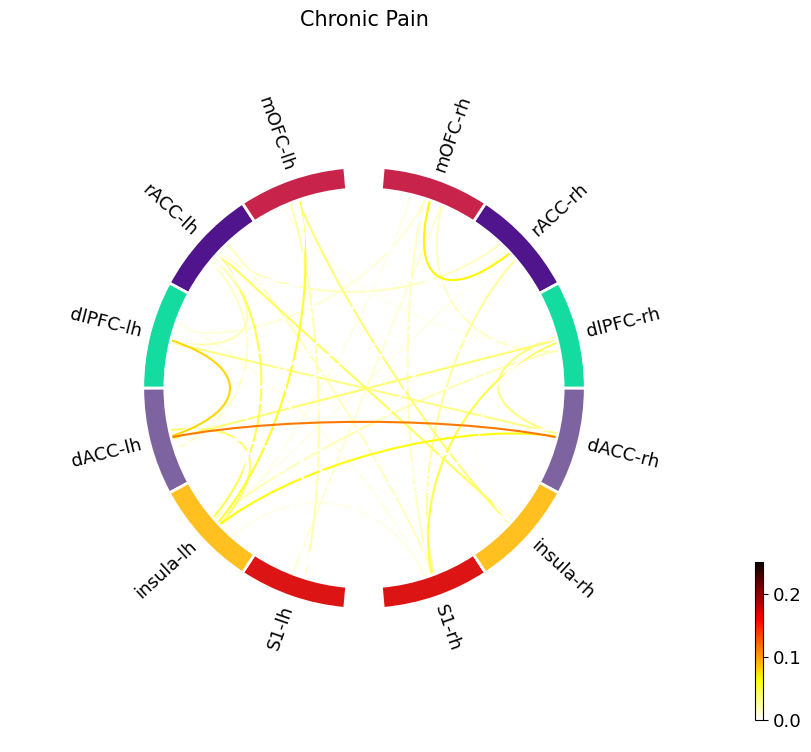

<Figure size 640x480 with 0 Axes>

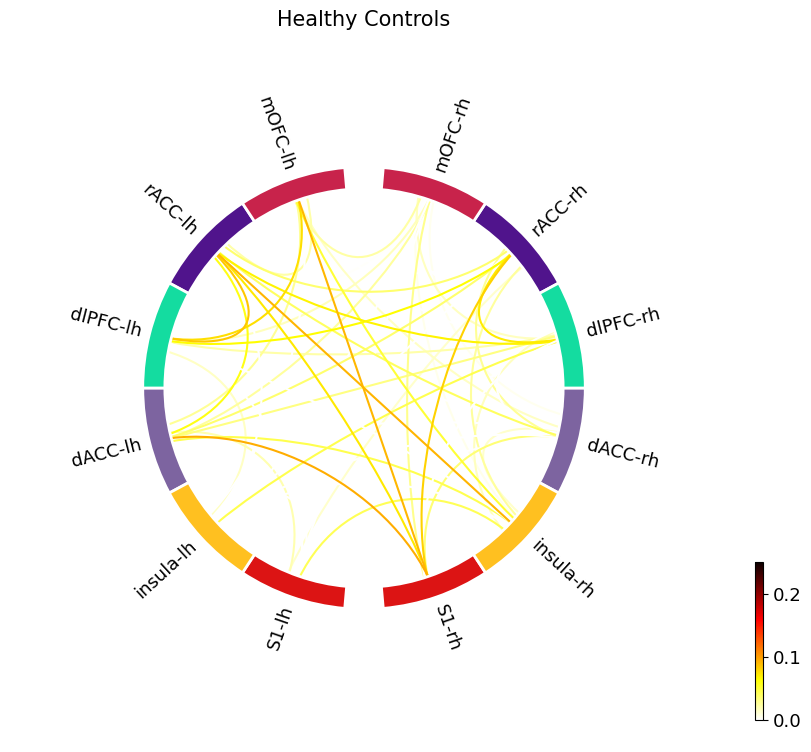

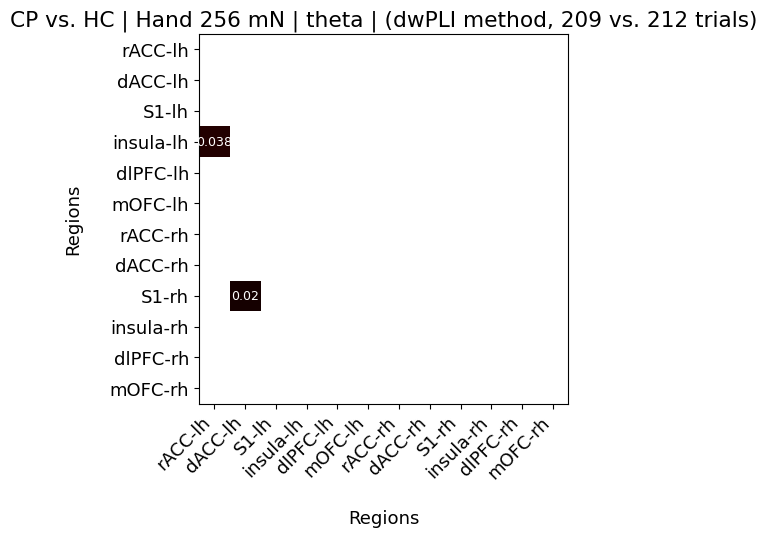

Hand 256 mN - Chronic Pain vs. Healthy Controls - wpli2_debiased - alpha
Top 3 Connections in Chronic Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| dlPFC-rh <-> S1-rh  |   4/19    |     0.543     |
| mOFC-rh <-> mOFC-lh |   3/19    |     0.47      |
|  S1-rh <-> mOFC-lh  |   3/19    |     0.365     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-lh <-> dlPFC-lh |   4/19    |     0.539     |
|  mOFC-lh <-> S1-lh   |   3/19    |     0.416     |
| insula-rh <-> S1-rh  |   2/19    |     0.636     |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+----------------+----------------+
| RO

<Figure size 640x480 with 0 Axes>

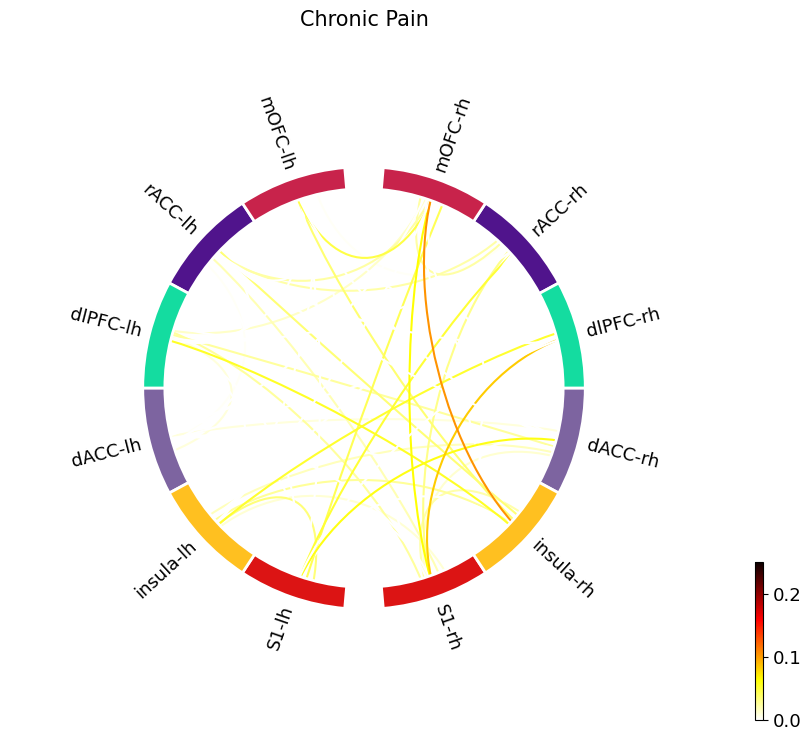

<Figure size 640x480 with 0 Axes>

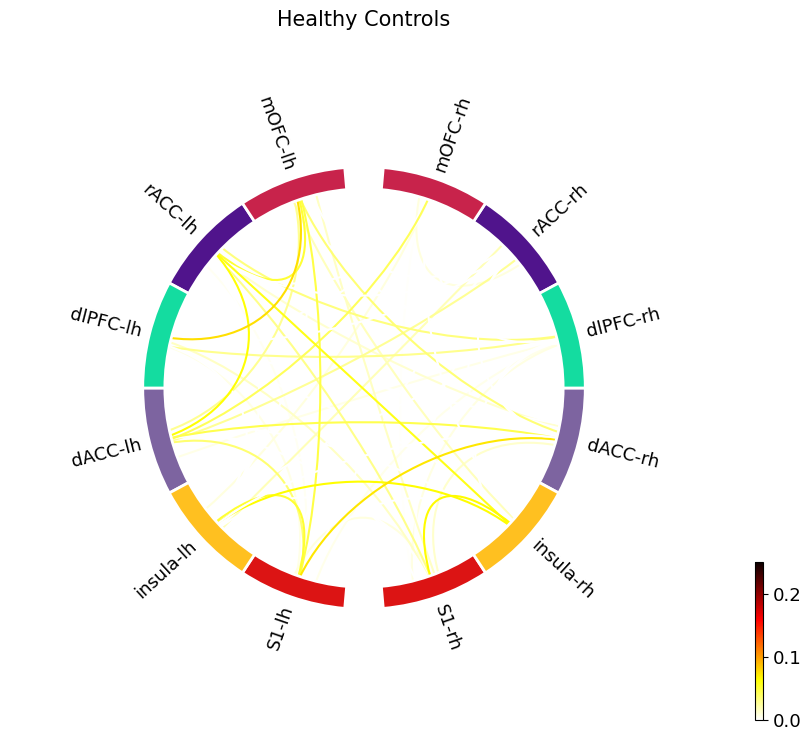

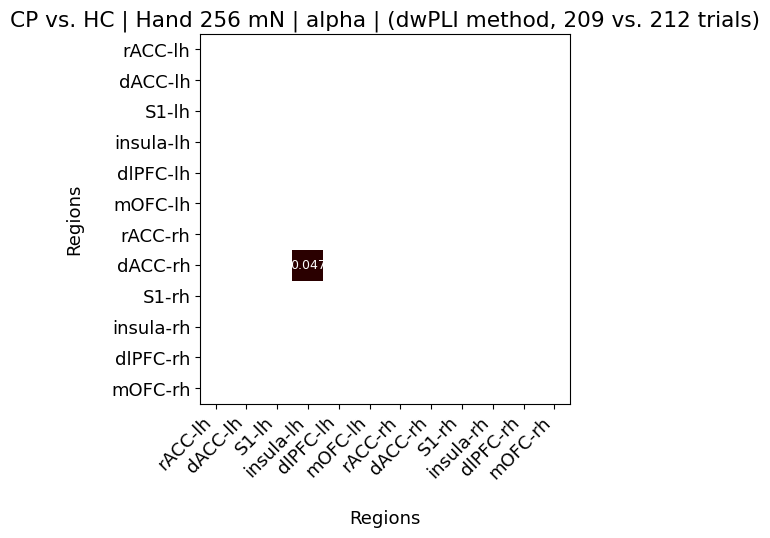

Hand 256 mN - Chronic Pain vs. Healthy Controls - wpli2_debiased - beta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| insula-rh <-> S1-lh  |   4/19    |     0.18      |
| dlPFC-lh <-> rACC-lh |   3/19    |     0.337     |
| rACC-rh <-> dlPFC-lh |   3/19    |     0.355     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-lh <-> dACC-lh |   4/19    |     0.239     |
| mOFC-lh <-> rACC-lh |   3/19    |     0.33      |
| dlPFC-rh <-> S1-rh  |   3/19    |     0.311     |
+---------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----------+---------+----------------+----------------+

<Figure size 640x480 with 0 Axes>

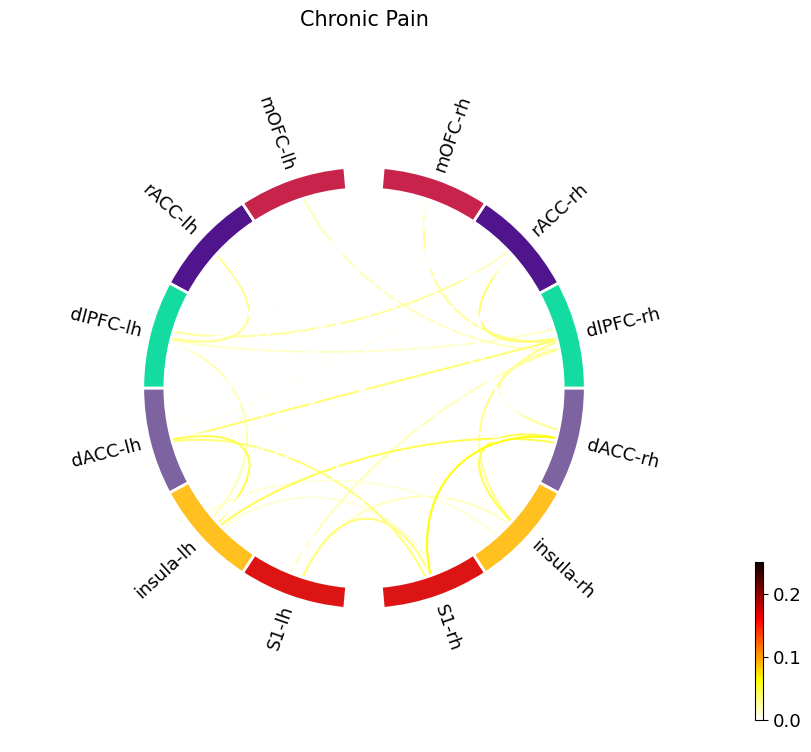

<Figure size 640x480 with 0 Axes>

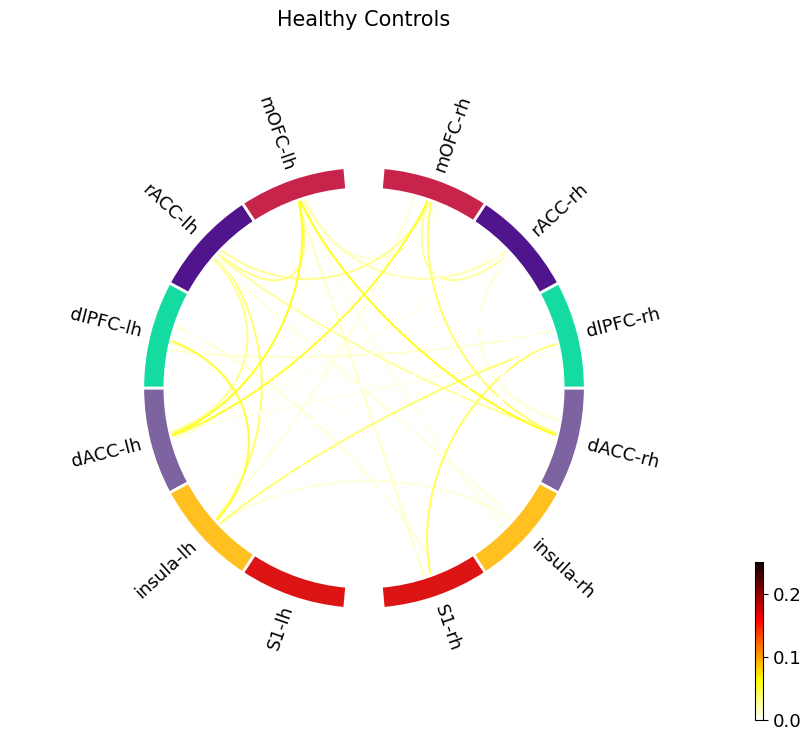

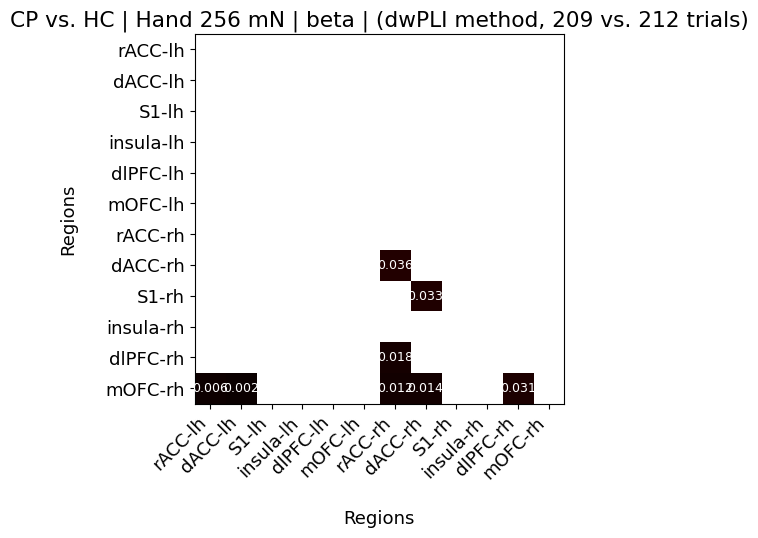

Hand 256 mN - Chronic Pain vs. Healthy Controls - wpli2_debiased - low-gamma
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|   rACC-rh <-> S1-lh   |   3/19    |     0.188     |
|  S1-rh <-> dlPFC-lh   |   3/19    |     0.264     |
| insula-rh <-> rACC-lh |   3/19    |     0.174     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
|  S1-rh <-> dACC-lh  |   3/19    |     0.256     |
| dACC-lh <-> rACC-lh |   3/19    |     0.167     |
| S1-rh <-> insula-lh |   2/19    |     0.158     |
+---------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+----------------+-----------

<Figure size 640x480 with 0 Axes>

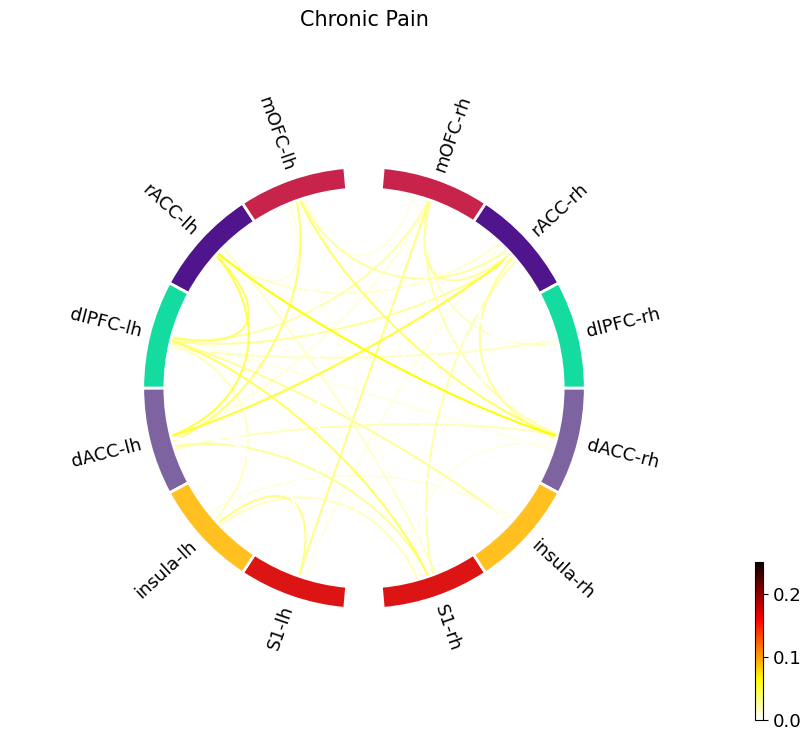

<Figure size 640x480 with 0 Axes>

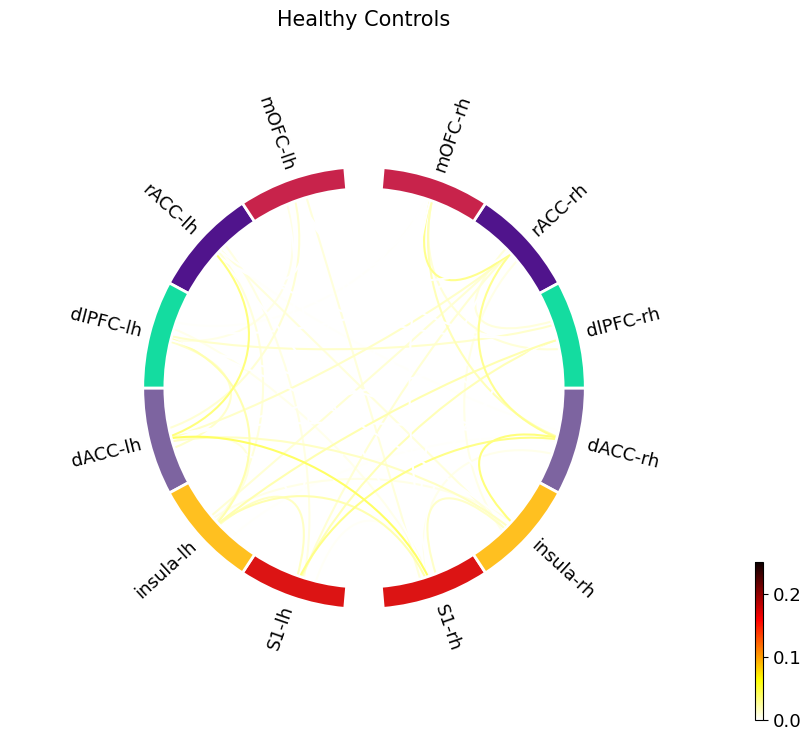

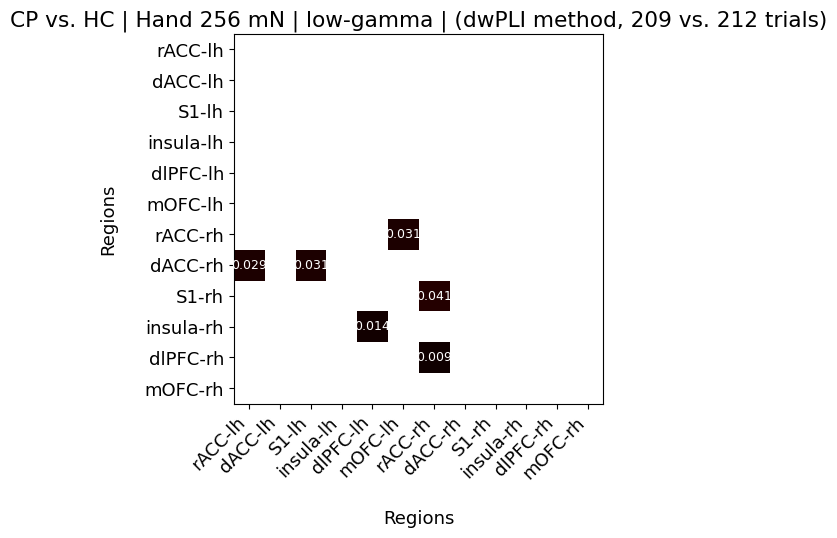

Hand 256 mN - Chronic Pain vs. Healthy Controls - wpli2_debiased - high-gamma
Top 3 Connections in Chronic Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> mOFC-lh  |   4/19    |     0.218     |
|  dACC-rh <-> rACC-rh   |   3/19    |     0.132     |
| dlPFC-rh <-> insula-rh |   3/19    |     0.122     |
+------------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dlPFC-lh <-> rACC-lh |   3/19    |     0.194     |
| insula-lh <-> S1-lh  |   3/19    |     0.134     |
|  S1-rh <-> dlPFC-lh  |   3/19    |     0.142     |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----------+---------+-------

<Figure size 640x480 with 0 Axes>

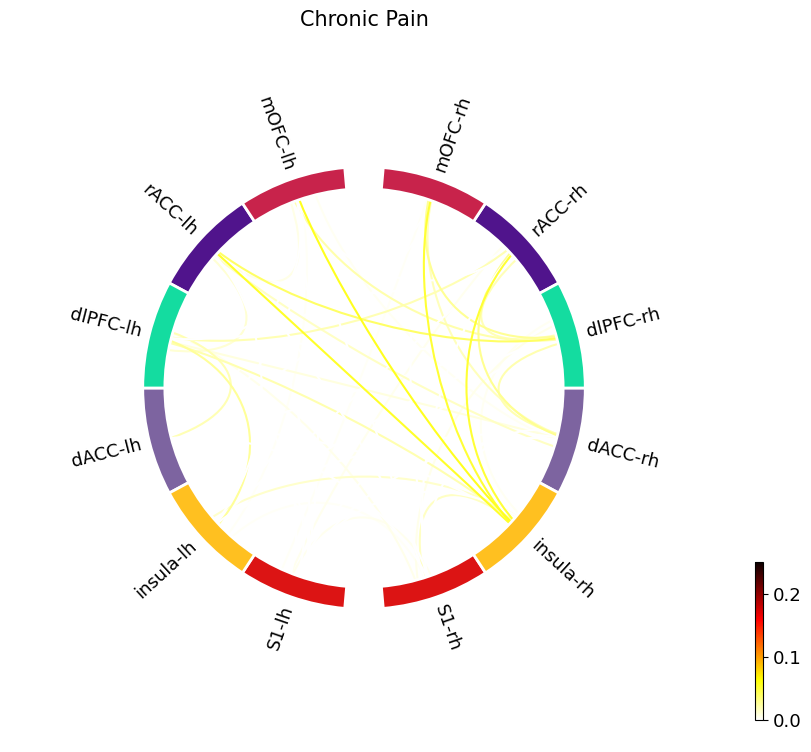

<Figure size 640x480 with 0 Axes>

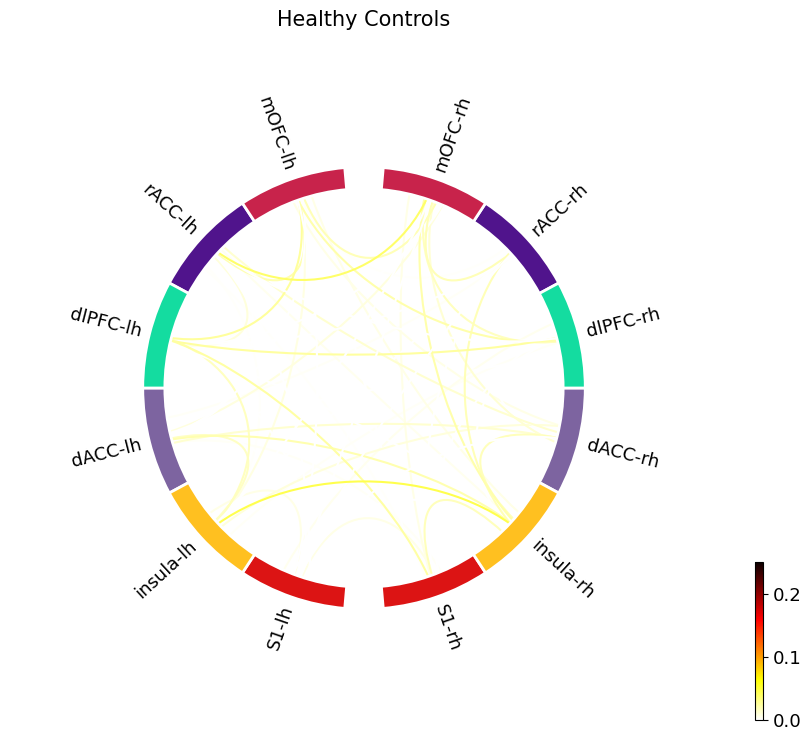

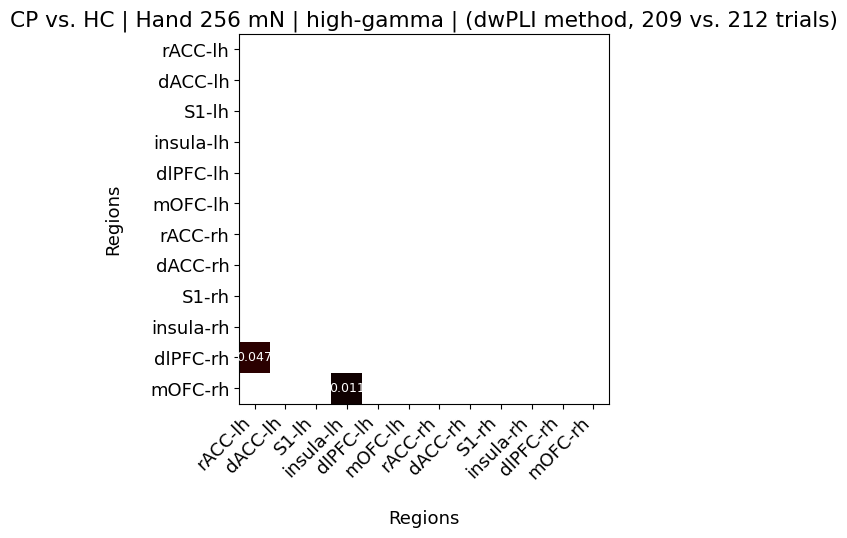

Eyes Open - Chronic Pain vs. Healthy Controls - aec_symmetric - theta
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dACC-rh <-> dACC-lh  |   8/19    |     0.387     |
|  rACC-rh <-> rACC-lh  |   8/19    |     0.367     |
| insula-rh <-> rACC-rh |   7/19    |     0.323     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   7/19    |     0.481     |
| insula-rh <-> rACC-lh |   5/19    |     0.359     |
|  rACC-rh <-> mOFC-lh  |   5/19    |     0.408     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+----------+---------+----------------

<Figure size 640x480 with 0 Axes>

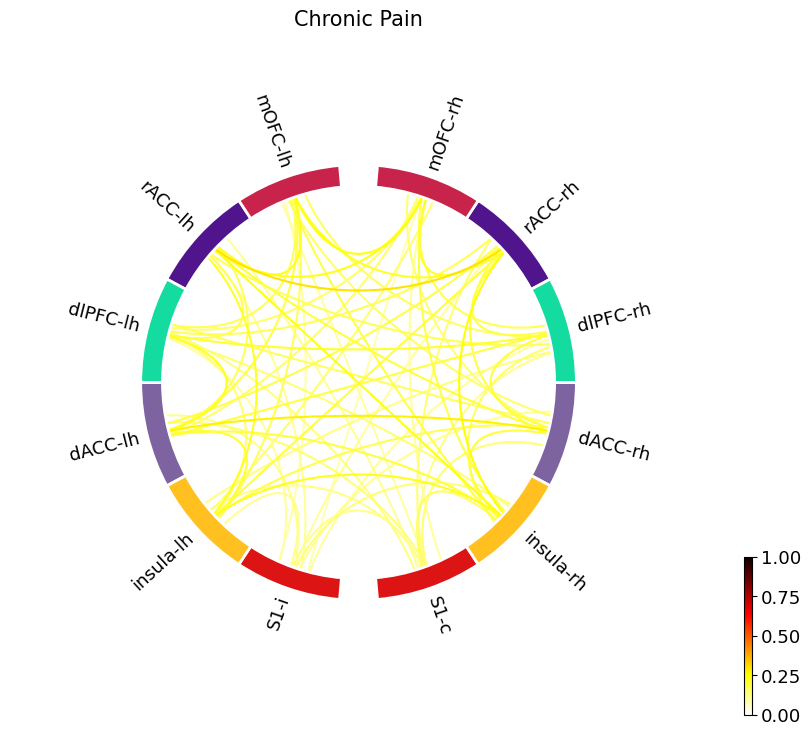

<Figure size 640x480 with 0 Axes>

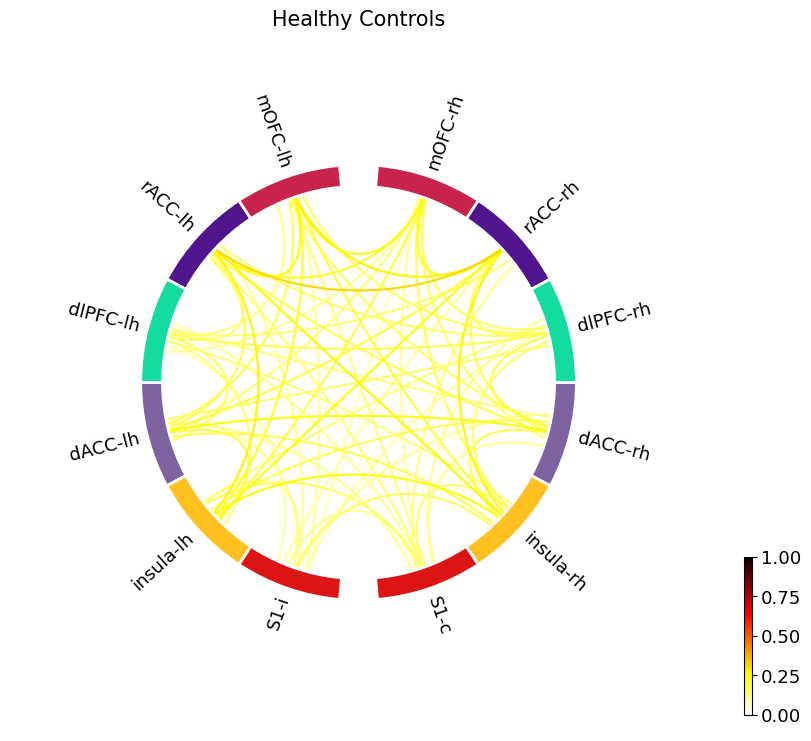

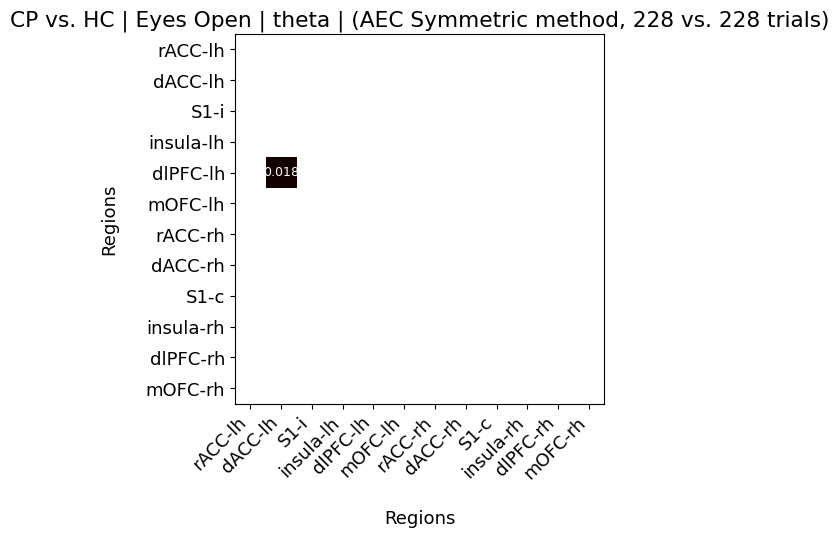

Eyes Open - Chronic Pain vs. Healthy Controls - aec_symmetric - alpha
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   9/19    |     0.368     |
| insula-rh <-> rACC-rh |   9/19    |     0.253     |
|  dACC-rh <-> dACC-lh  |   6/19    |     0.394     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
|   dACC-rh <-> dACC-lh   |   8/19    |     0.33      |
|   rACC-rh <-> rACC-lh   |   7/19    |     0.319     |
| insula-rh <-> insula-lh |   6/19    |     0.283     |
+-------------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+-------

<Figure size 640x480 with 0 Axes>

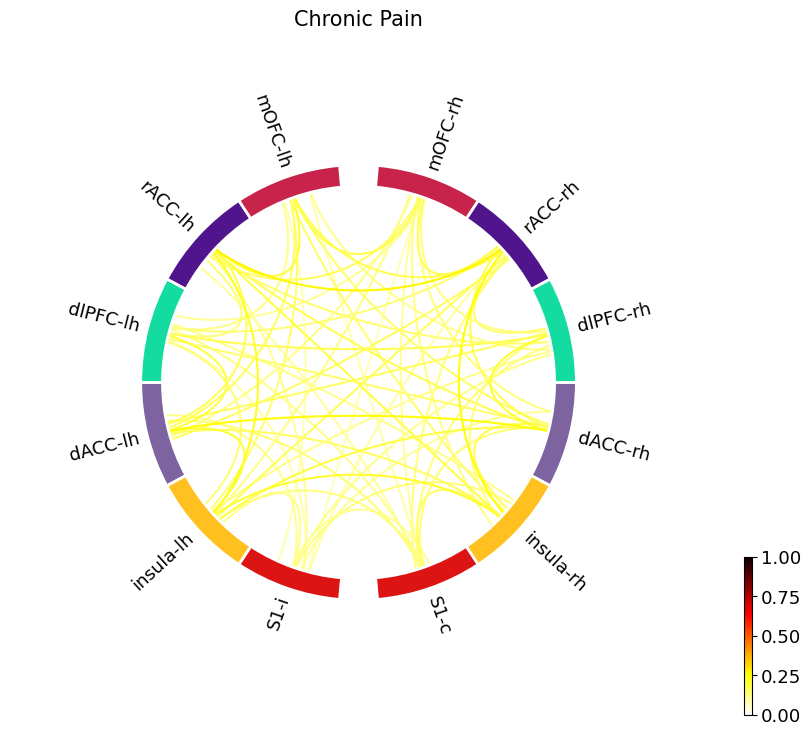

<Figure size 640x480 with 0 Axes>

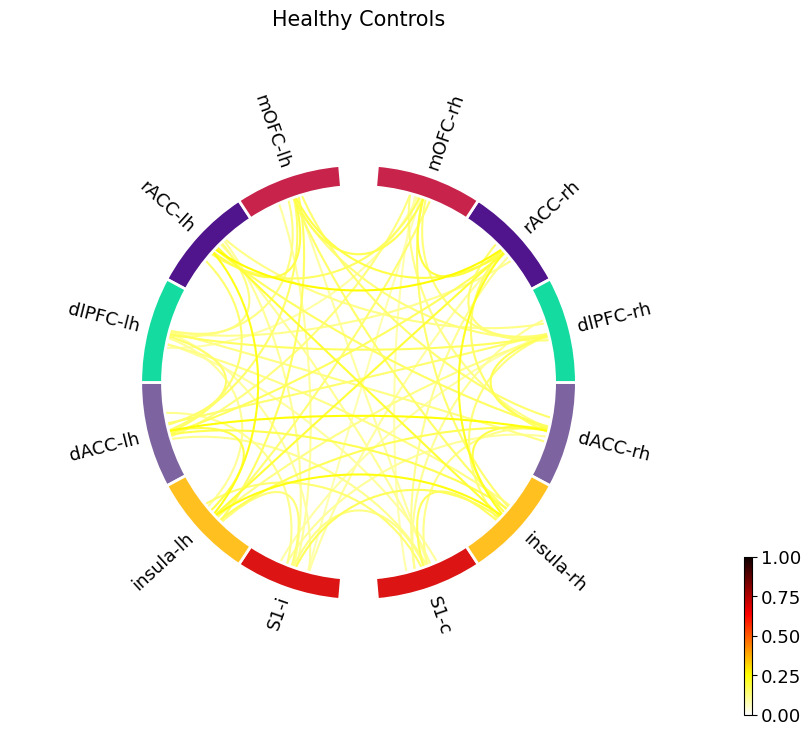

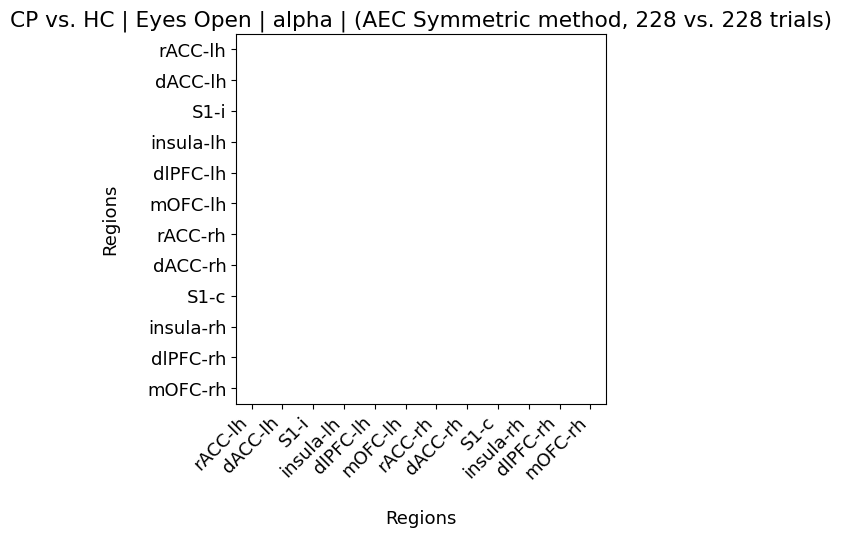

Eyes Open - Chronic Pain vs. Healthy Controls - aec_symmetric - beta
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   14/19   |     0.291     |
| insula-rh <-> rACC-rh |   9/19    |     0.262     |
|  dACC-rh <-> dACC-lh  |   7/19    |     0.229     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   11/19   |     0.295     |
|  dACC-rh <-> dACC-lh  |   5/19    |     0.226     |
| insula-lh <-> rACC-lh |   4/19    |     0.233     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+----------------+-----

<Figure size 640x480 with 0 Axes>

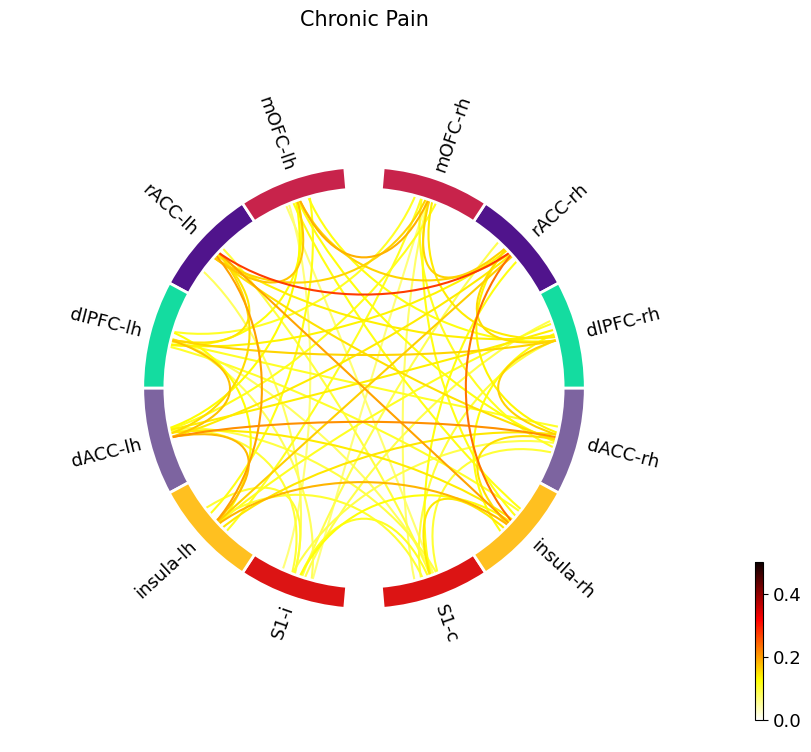

<Figure size 640x480 with 0 Axes>

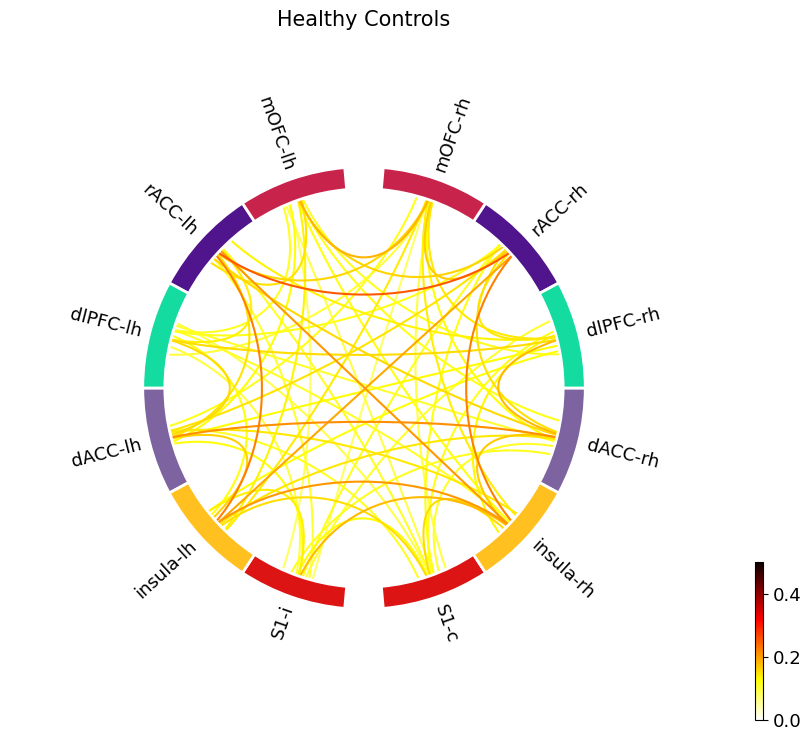

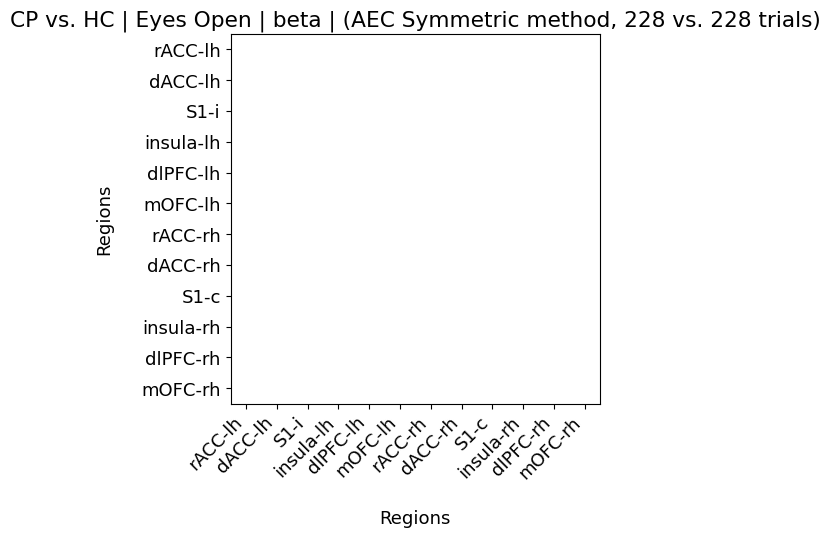

Eyes Open - Chronic Pain vs. Healthy Controls - aec_symmetric - low-gamma
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   13/19   |     0.304     |
| insula-rh <-> rACC-rh |   12/19   |     0.273     |
| insula-lh <-> rACC-lh |   6/19    |     0.303     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   12/19   |     0.292     |
| insula-lh <-> rACC-lh |   9/19    |     0.215     |
| insula-rh <-> rACC-rh |   5/19    |     0.343     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+----------------+

<Figure size 640x480 with 0 Axes>

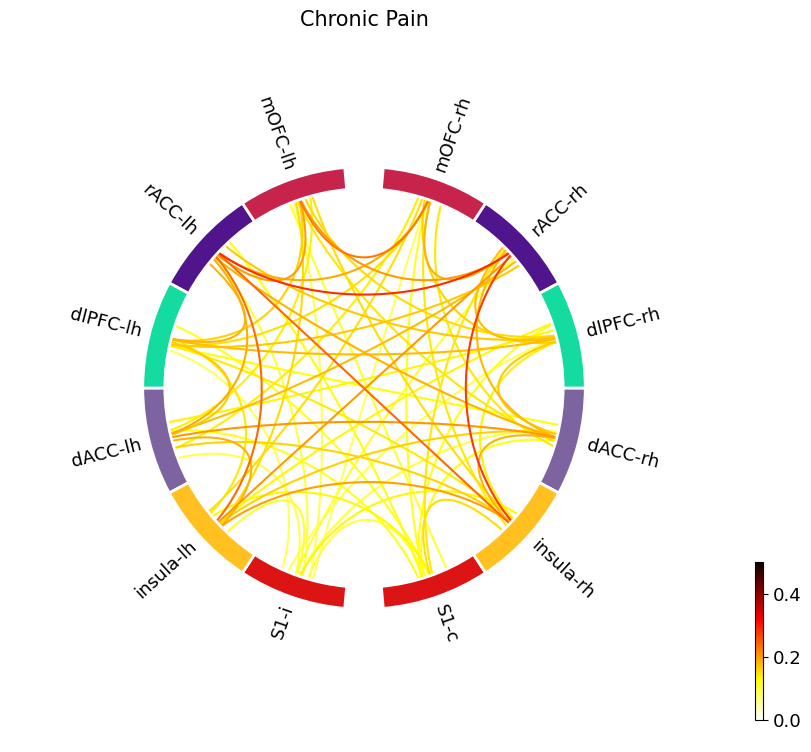

<Figure size 640x480 with 0 Axes>

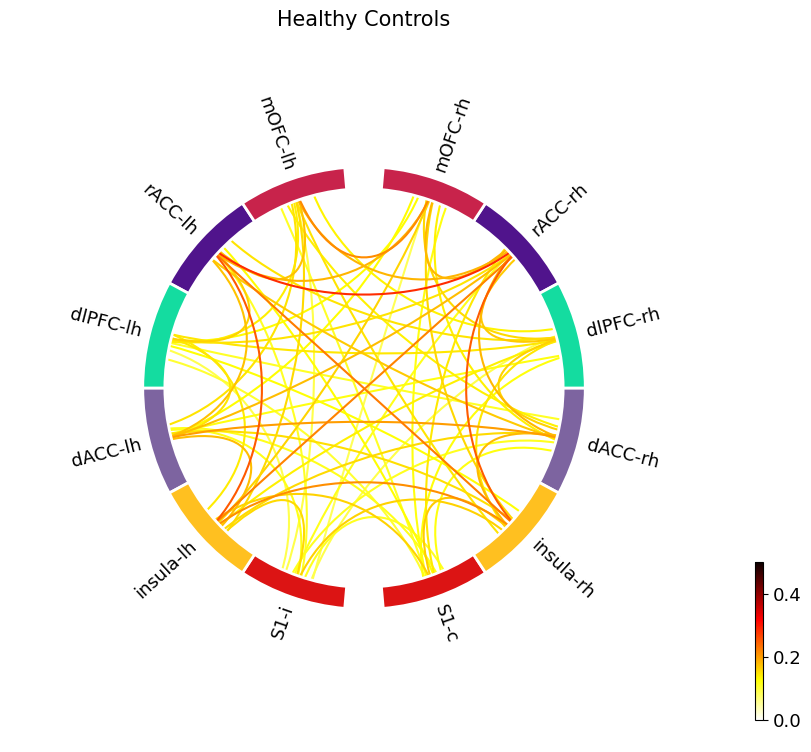

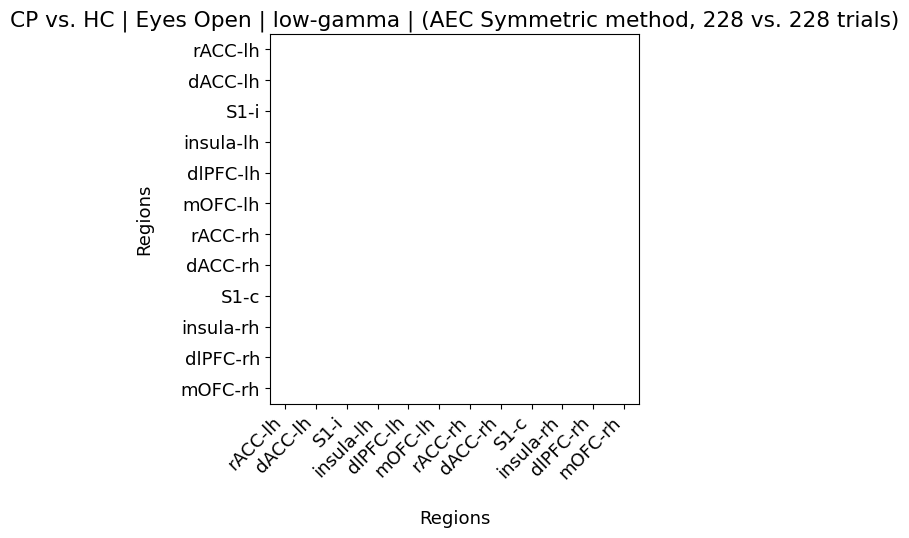

Eyes Open - Chronic Pain vs. Healthy Controls - aec_symmetric - high-gamma
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   12/19   |     0.336     |
| insula-rh <-> rACC-rh |   11/19   |     0.293     |
| insula-rh <-> rACC-lh |   5/19    |     0.226     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Controls group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   13/19   |     0.311     |
| insula-lh <-> rACC-lh |   6/19    |     0.236     |
| insula-rh <-> rACC-lh |   6/19    |     0.237     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+---------+----------------

<Figure size 640x480 with 0 Axes>

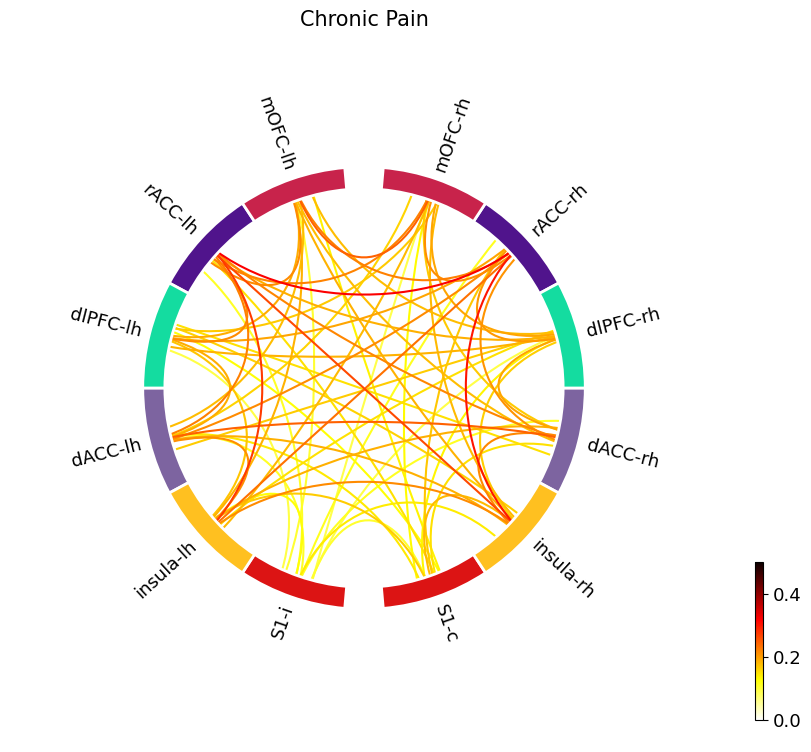

<Figure size 640x480 with 0 Axes>

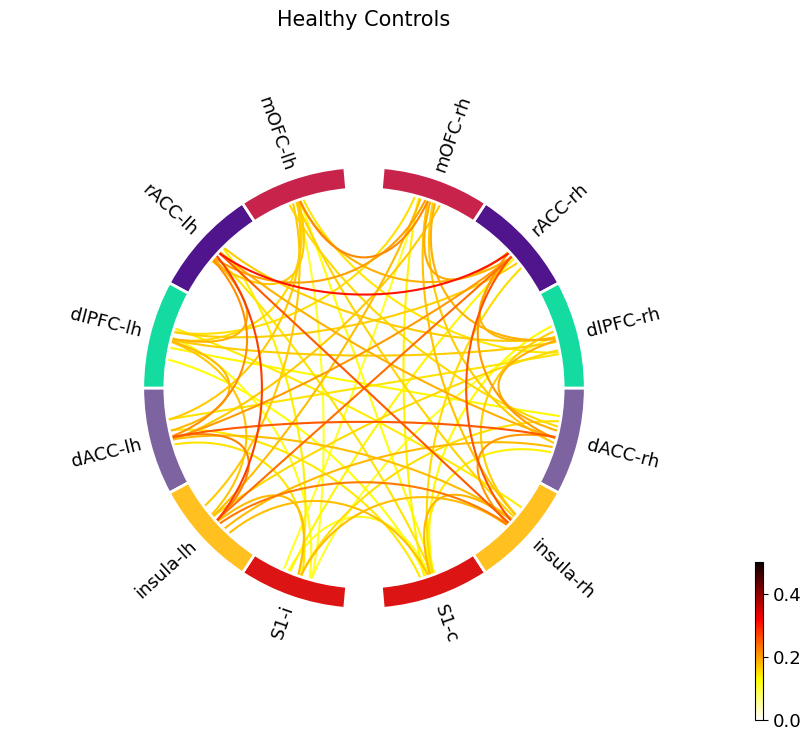

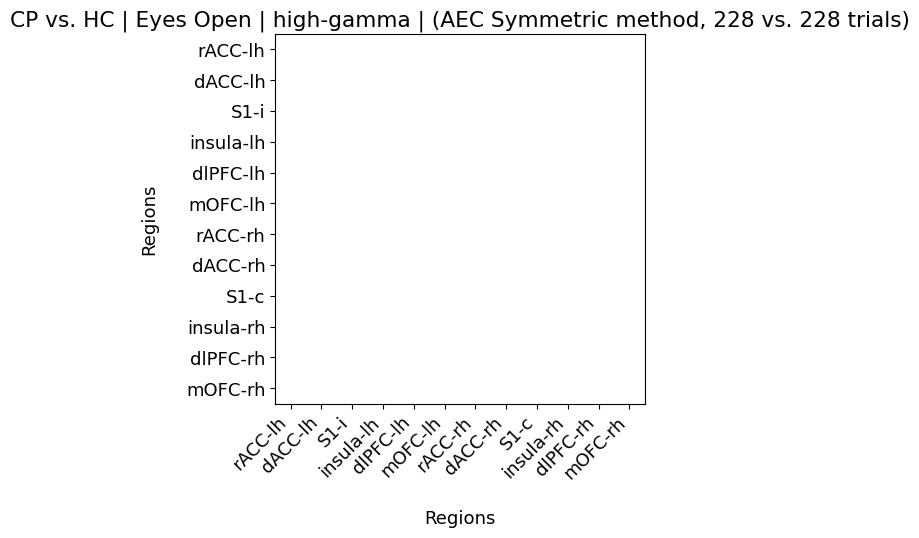

In [40]:
# Widespread Pain vs Localized Pain
these_group_names = ["Chronic Pain", "Healthy Controls", "Mann_Whitney_U_test"]
these_group_cons = [group_con_CP, group_con_HC]
these_sub_cons = [sub_con_CP, sub_con_HC]
these_sub_ids = [sub_ids_CP, sub_ids_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        # Ignore some specific condition/method combinations
        if condition=="Hand 256 mN" and "aec" in method:
            continue
        elif condition=="Eyes Open" and method=="wpli2_debiased":
            continue

        for band in band_names:
            ## Save all output to a text file
            # Backup original stdout  
            orig_stdout = sys.stdout  
            if method=="wpli2_debiased":
                f = open(stats_save_path / f'{condition}_{band}_dwPLI.txt', 'w')  
            else:
                f = open(stats_save_path / f'{condition}_{band}_{method}.txt', 'w')
                
            # Set stdout to the file object  
            if save_txt:
                sys.stdout = f  
            
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            top_3_info=None
            group_con=None
            for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]
                    if 'Eyes' in condition:
                        table_data.append([f"{roi_acronyms_resting[connection[0]]} <-> {roi_acronyms_resting[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                    else:
                        table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            print(group1_stack.shape)
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack,
                group2_stack,
                roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                sub_ids1=these_sub_ids[0],
                sub_ids2=these_sub_ids[1],
                condition=condition,
                bilateral_pain_ids=bilateral_pain_ids,
                round_neg_vals=round_neg_vals,
                method=method)

            # Need to custom set this because the colors blow out
            if 'Eyes' in condition and band in ["theta","alpha"]:
                vmin = 0.0
                vmax = 1.0
            elif 'Eyes' in condition and band not in ["theta","alpha"]:
                vmin = 0.0
                vmax = 0.5
            else:
                vmin = None
                vmax = None
            
            # Plotting
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                condition=condition,
                vmin=vmin,
                vmax=vmax,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "CP vs. HC",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )
            
            # Compute the centrality and test
            fc.compute_centrality_and_test(group1_stack,
                                            group2_stack, 
                                            roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                                            sub_ids1=these_sub_ids[0],
                                            sub_ids2=these_sub_ids[1],
                                            bilateral_pain_ids=bilateral_pain_ids,
                                            condition=condition,
                                            )
            
            print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
            fc.plot_connectivity_and_stats(means_1=means_1,
                                        means_2=means_2,
                                        sem_1=sem_1,
                                        sem_2=sem_2,
                                        p_values=p_values,
                                        **plot_kwargs,
                                        save_fig=True,
                                        highlight_pvals=highlight_pvals,
                                        min_fc_val=None,
                                        set_title=set_title,
                                        show_fc_vals=show_fc_vals,
                                        round_neg_vals=round_neg_vals,
            )
        
            # Reset the standard output to its original value  
            sys.stdout = orig_stdout  
            
            f.close()  
        
            if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(
                            zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(
                            EO_resting_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(
                            EC_resting_data_path, f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
            

### WSP vs. LP Plots

Hand 256 mN - Chronic Widespread Pain vs. Chronic Localized Pain - wpli2_debiased - theta
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> rACC-lh |   3/12    |     0.285     |
| dlPFC-rh <-> dACC-lh  |   2/12    |     0.266     |
|   rACC-rh <-> S1-lh   |   2/12    |     0.375     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh  |   4/12    |     0.547     |
| dACC-rh <-> dlPFC-lh |   3/12    |     0.572     |
| dACC-rh <-> dACC-lh  |   3/12    |     0.383     |
+----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+-----+-

<Figure size 640x480 with 0 Axes>

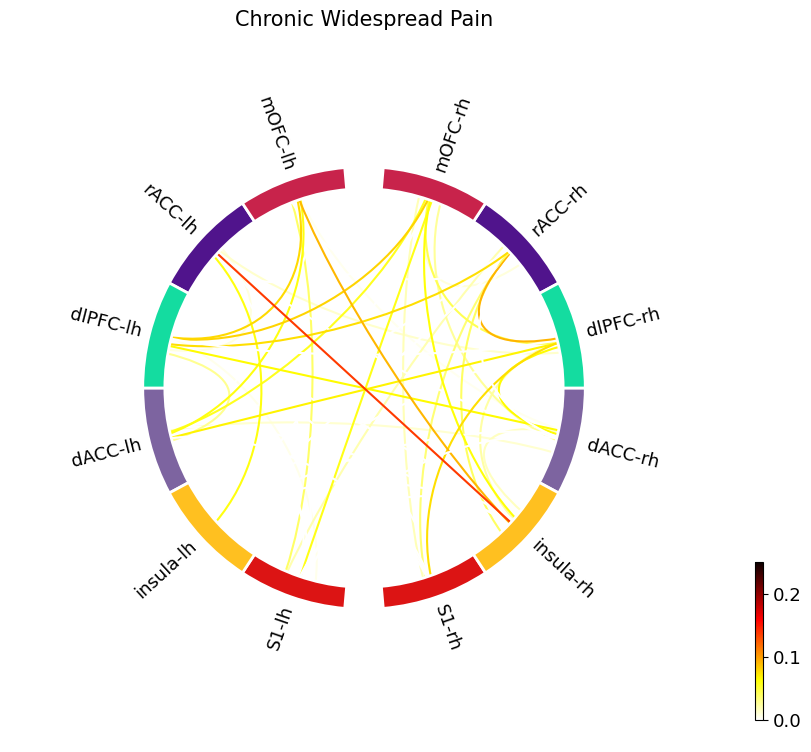

<Figure size 640x480 with 0 Axes>

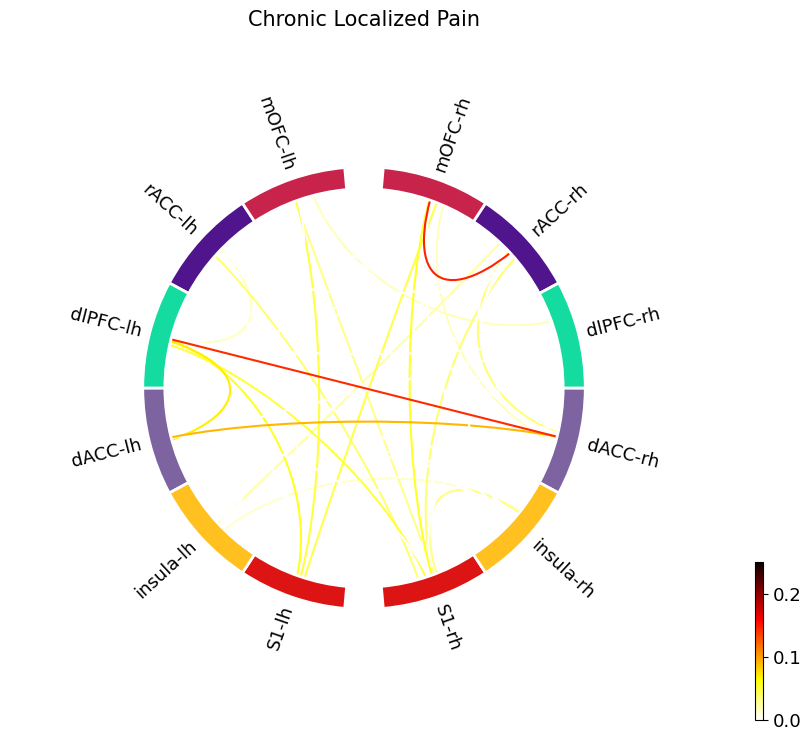

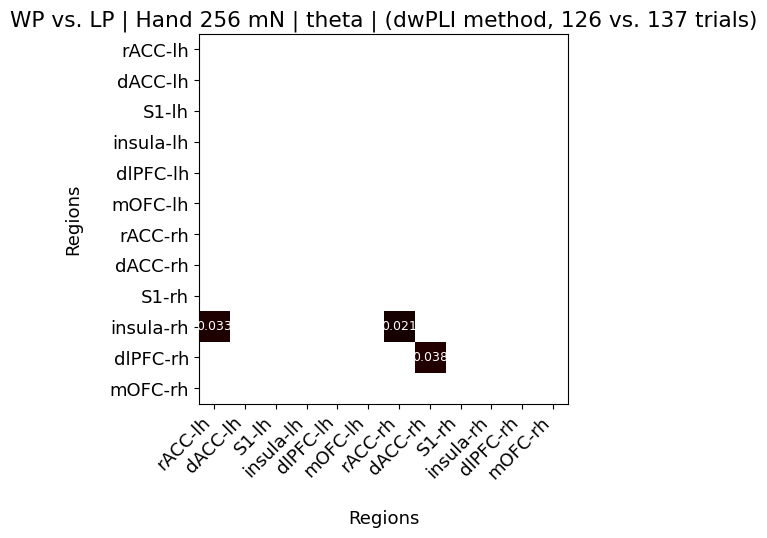

Hand 256 mN - Chronic Widespread Pain vs. Chronic Localized Pain - wpli2_debiased - alpha
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dlPFC-rh <-> S1-rh   |   3/12    |     0.516     |
|  mOFC-rh <-> mOFC-lh  |   2/12    |     0.52      |
| mOFC-lh <-> insula-lh |   2/12    |     0.28      |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-------------------+-----------+---------------+
|    Connection     | Frequency | Mean Strength |
+-------------------+-----------+---------------+
| S1-rh <-> rACC-lh |   2/12    |     0.296     |
| S1-rh <-> rACC-rh |   2/12    |     0.43      |
| mOFC-rh <-> S1-rh |   2/12    |     0.349     |
+-------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+-----------+---------+------

<Figure size 640x480 with 0 Axes>

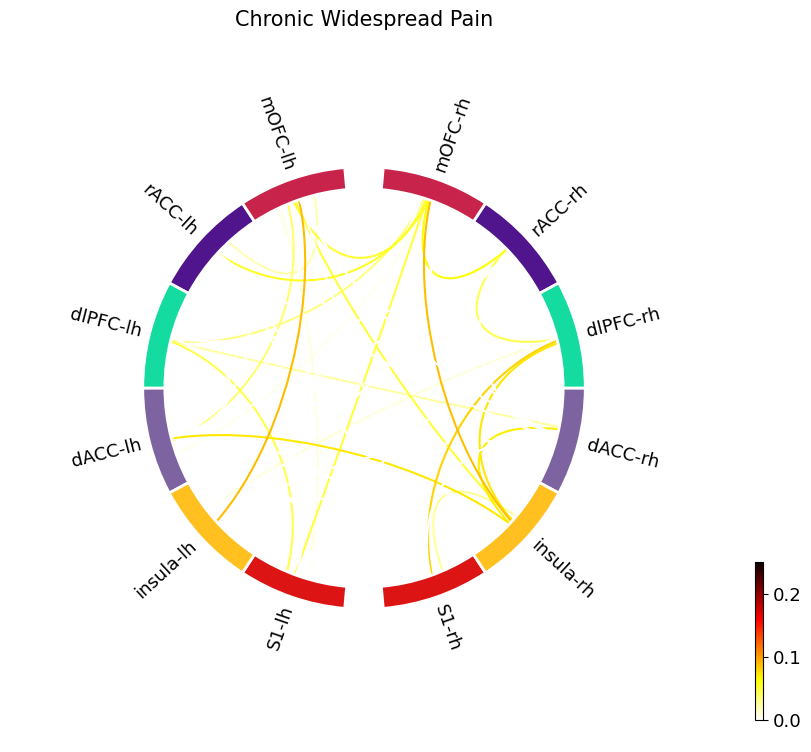

<Figure size 640x480 with 0 Axes>

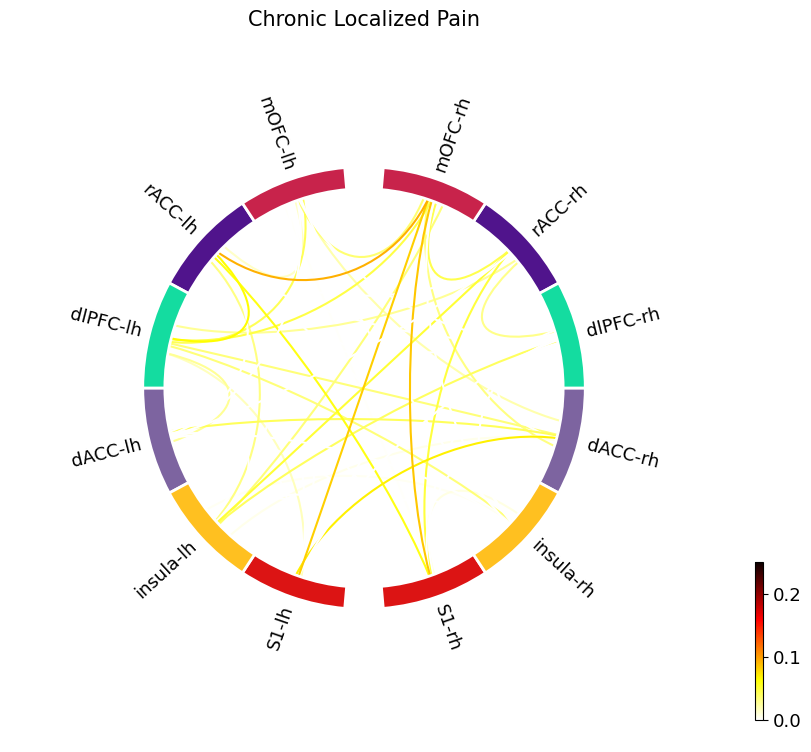

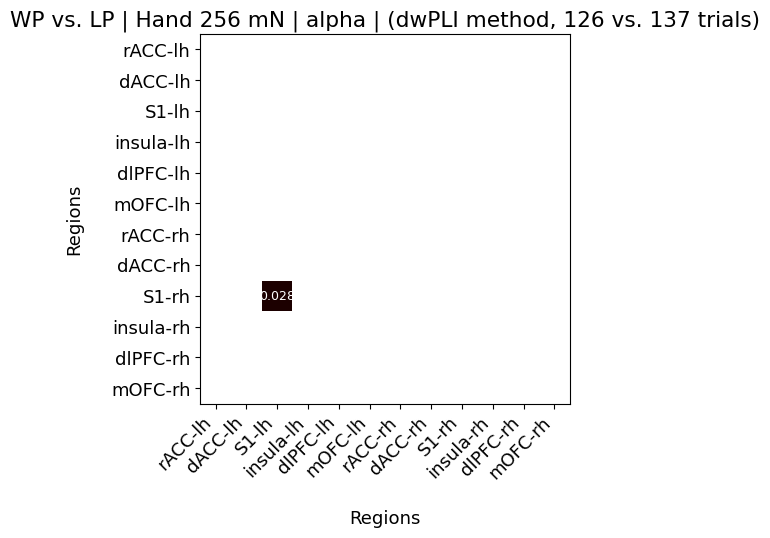

Hand 256 mN - Chronic Widespread Pain vs. Chronic Localized Pain - wpli2_debiased - beta
Top 3 Connections in Chronic Widespread Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| insula-rh <-> S1-lh |   2/12    |     0.154     |
|  S1-lh <-> rACC-lh  |   2/12    |     0.278     |
|  rACC-rh <-> S1-lh  |   2/12    |     0.202     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> dACC-lh |   3/12    |     0.198     |
| mOFC-rh <-> dlPFC-rh  |   2/12    |     0.189     |
|  rACC-rh <-> dACC-lh  |   2/12    |     0.214     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+-----+---------

<Figure size 640x480 with 0 Axes>

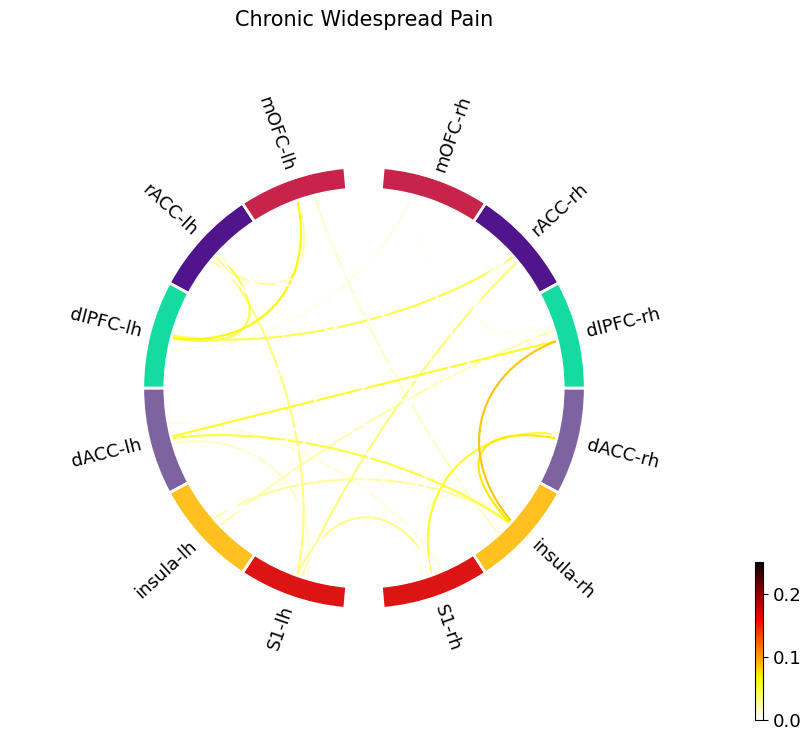

<Figure size 640x480 with 0 Axes>

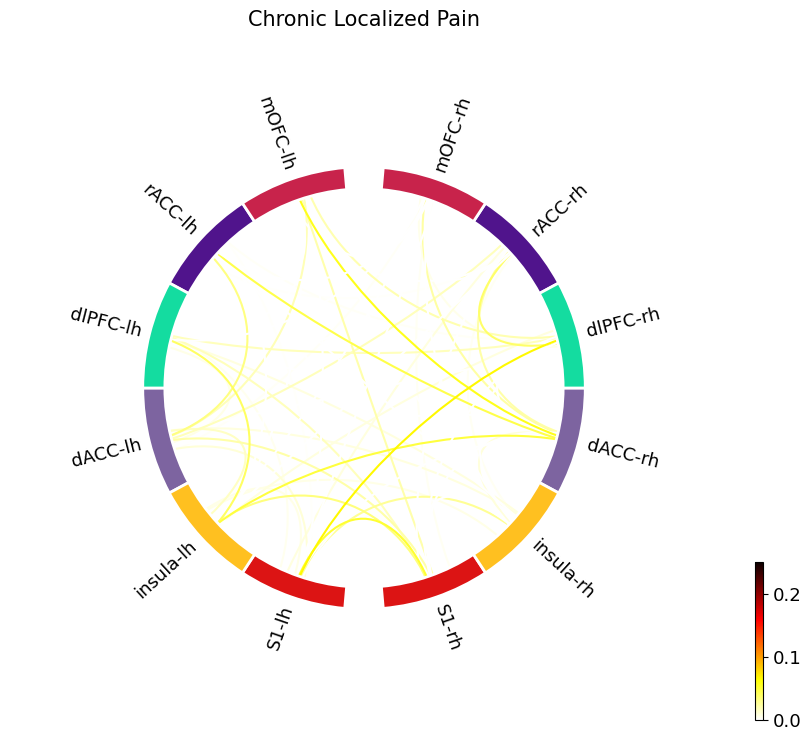

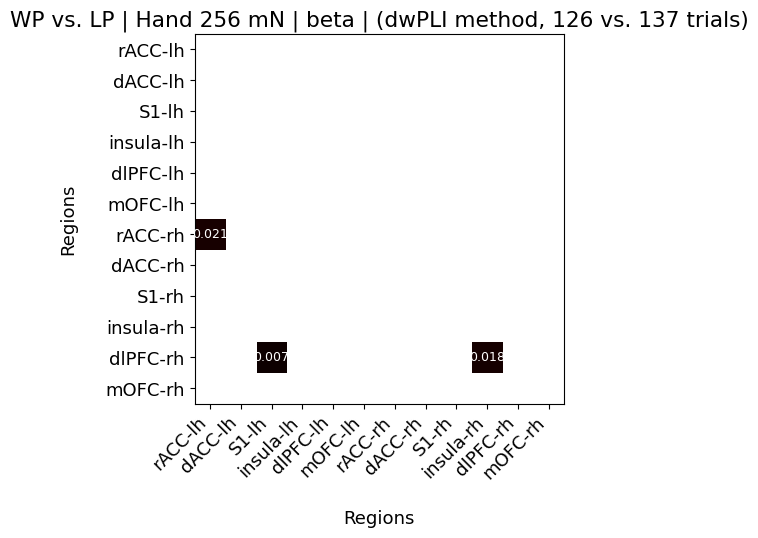

Hand 256 mN - Chronic Widespread Pain vs. Chronic Localized Pain - wpli2_debiased - low-gamma
Top 3 Connections in Chronic Widespread Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> rACC-lh  |   4/12    |     0.166     |
|  dACC-rh <-> S1-lh   |   2/12    |     0.136     |
| dlPFC-lh <-> rACC-lh |   2/12    |     0.18      |
+----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> rACC-lh  |   3/12    |     0.168     |
|  mOFC-rh <-> dACC-rh   |   2/12    |     0.158     |
| dlPFC-rh <-> insula-rh |   2/12    |     0.11      |
+------------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Regio

<Figure size 640x480 with 0 Axes>

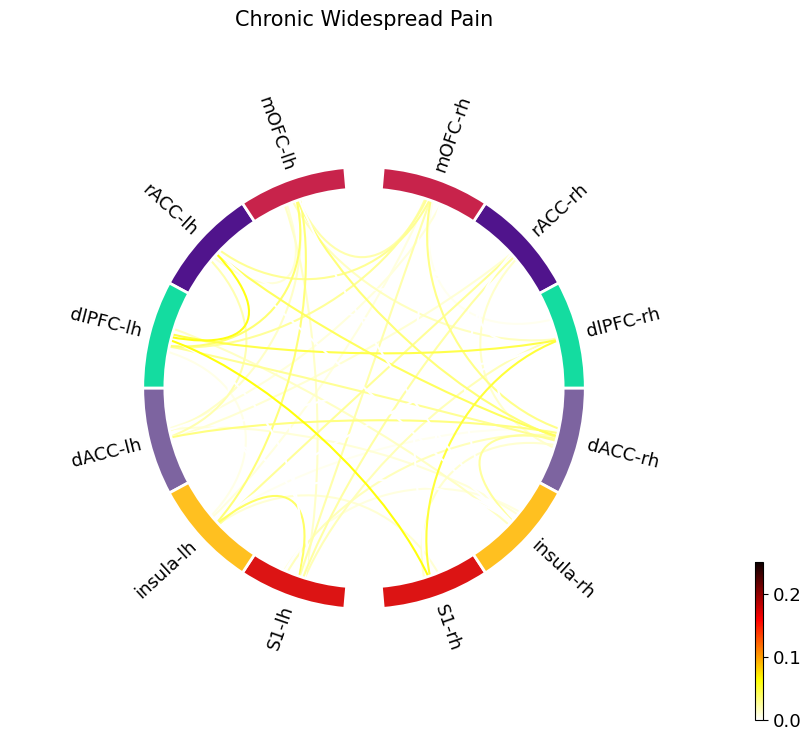

<Figure size 640x480 with 0 Axes>

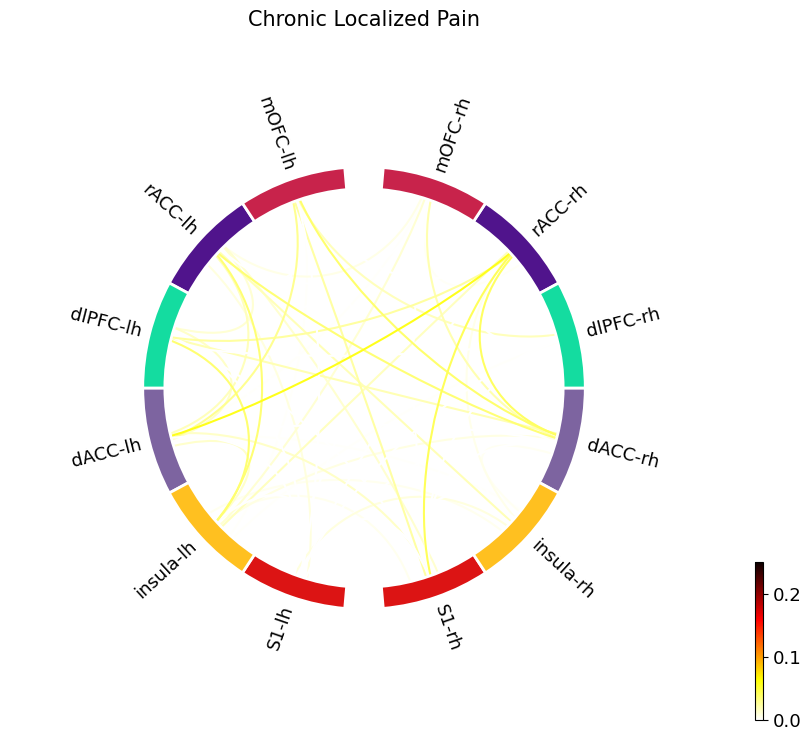

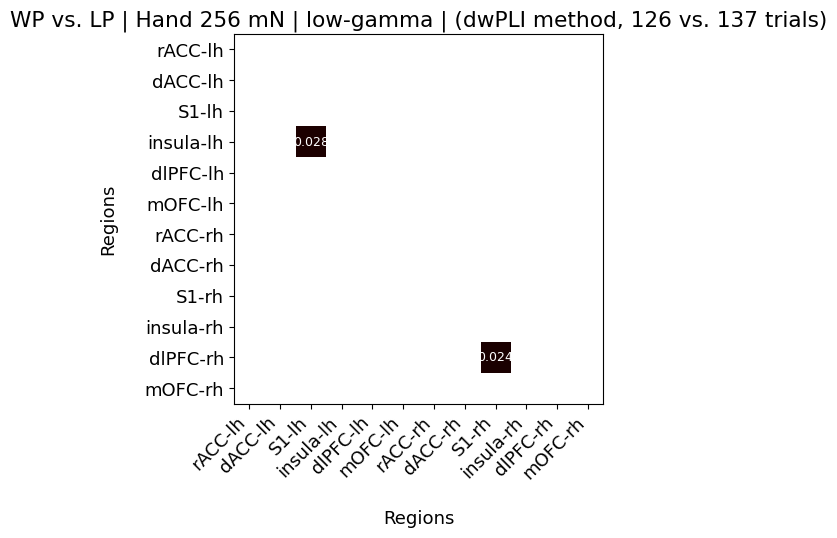

Hand 256 mN - Chronic Widespread Pain vs. Chronic Localized Pain - wpli2_debiased - high-gamma
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| dlPFC-rh <-> dACC-lh  |   2/12    |     0.222     |
| dlPFC-rh <-> dACC-rh  |   2/12    |     0.146     |
| dACC-rh <-> insula-lh |   2/12    |     0.152     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| mOFC-lh <-> insula-lh  |   2/12    |     0.169     |
| dlPFC-rh <-> insula-rh |   2/12    |     0.136     |
|   S1-lh <-> dACC-lh    |   2/12    |     0.144     |
+------------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality 

<Figure size 640x480 with 0 Axes>

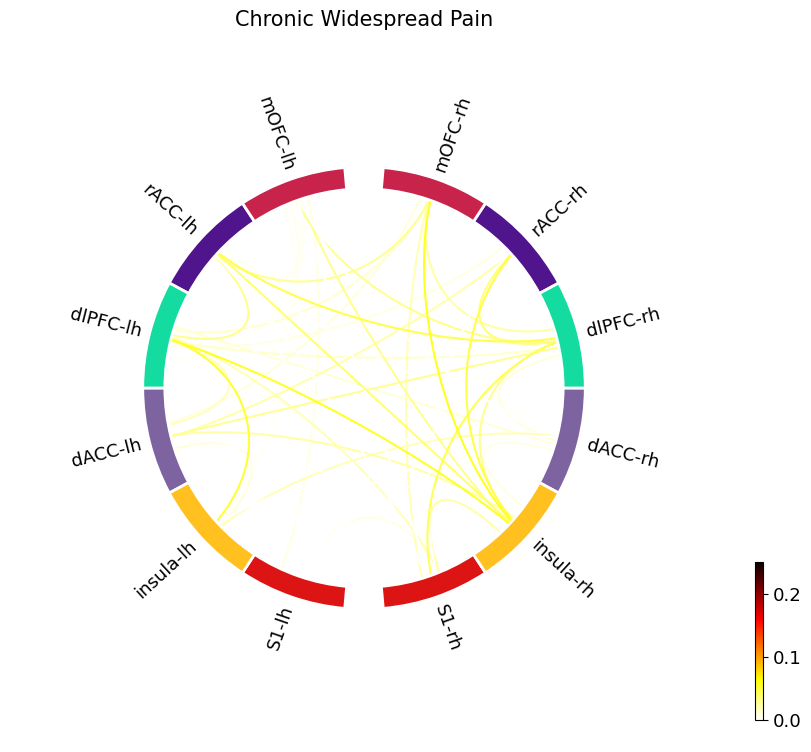

<Figure size 640x480 with 0 Axes>

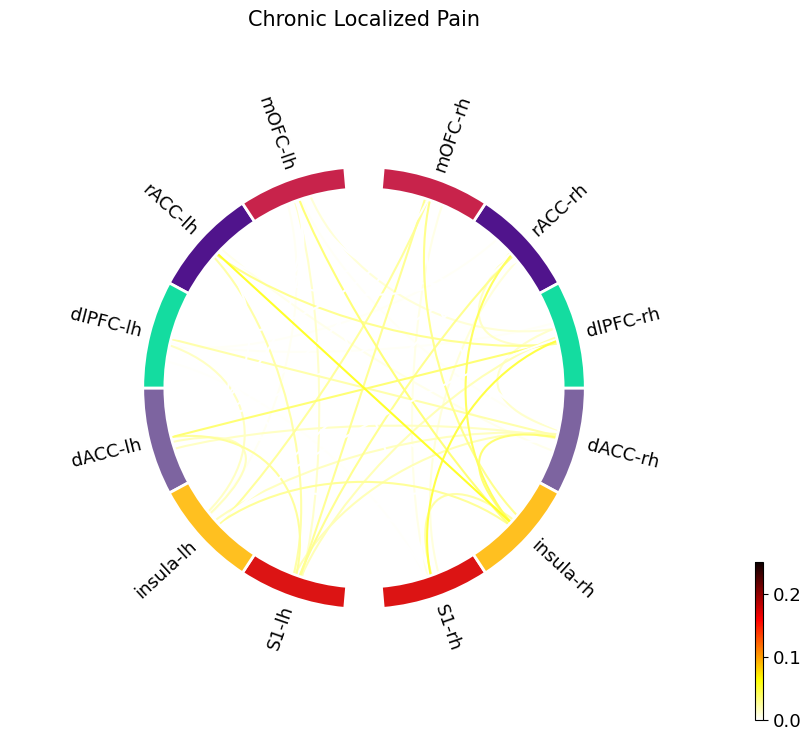

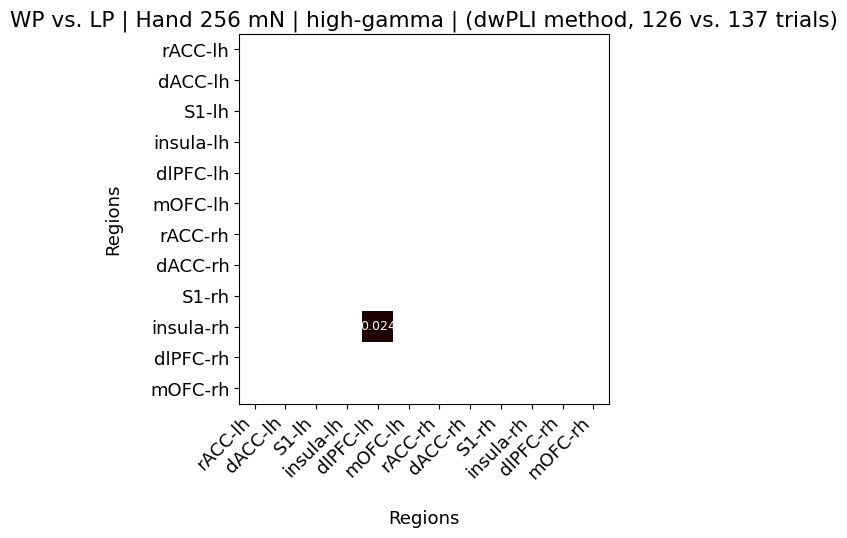

Eyes Open - Chronic Widespread Pain vs. Chronic Localized Pain - aec_symmetric - theta
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   6/12    |     0.339     |
|  dACC-rh <-> dACC-lh  |   5/12    |     0.383     |
| insula-rh <-> rACC-rh |   4/12    |     0.326     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   7/12    |     0.389     |
|  dACC-rh <-> dACC-lh  |   4/12    |     0.381     |
| insula-lh <-> rACC-lh |   4/12    |     0.333     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+---

<Figure size 640x480 with 0 Axes>

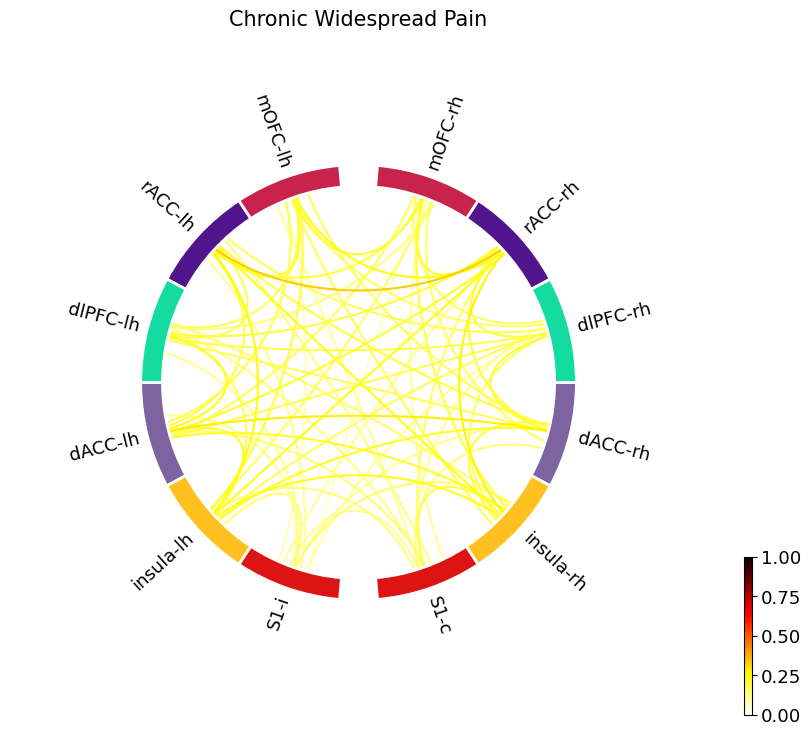

<Figure size 640x480 with 0 Axes>

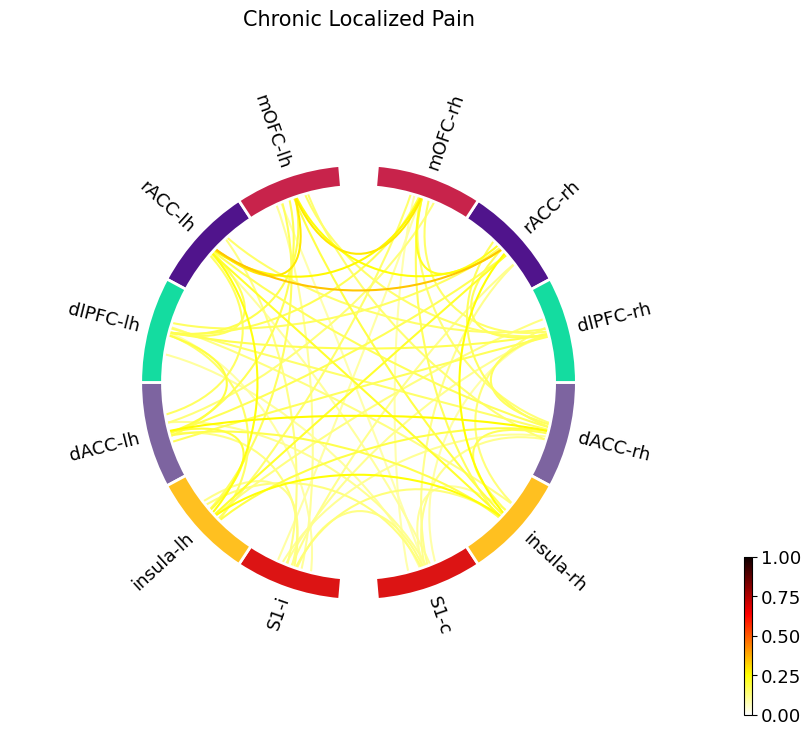

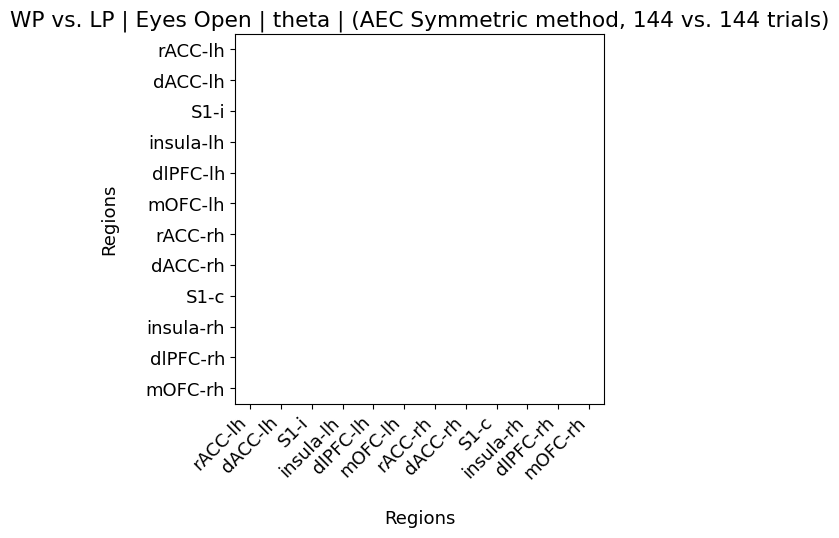

Eyes Open - Chronic Widespread Pain vs. Chronic Localized Pain - aec_symmetric - alpha
Top 3 Connections in Chronic Widespread Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| rACC-rh <-> rACC-lh  |   7/12    |     0.297     |
| dACC-rh <-> dACC-lh  |   4/12    |     0.35      |
| dlPFC-rh <-> dACC-rh |   3/12    |     0.385     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   8/12    |     0.314     |
| insula-rh <-> rACC-rh |   4/12    |     0.222     |
|  mOFC-lh <-> rACC-lh  |   3/12    |     0.293     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+---------+

<Figure size 640x480 with 0 Axes>

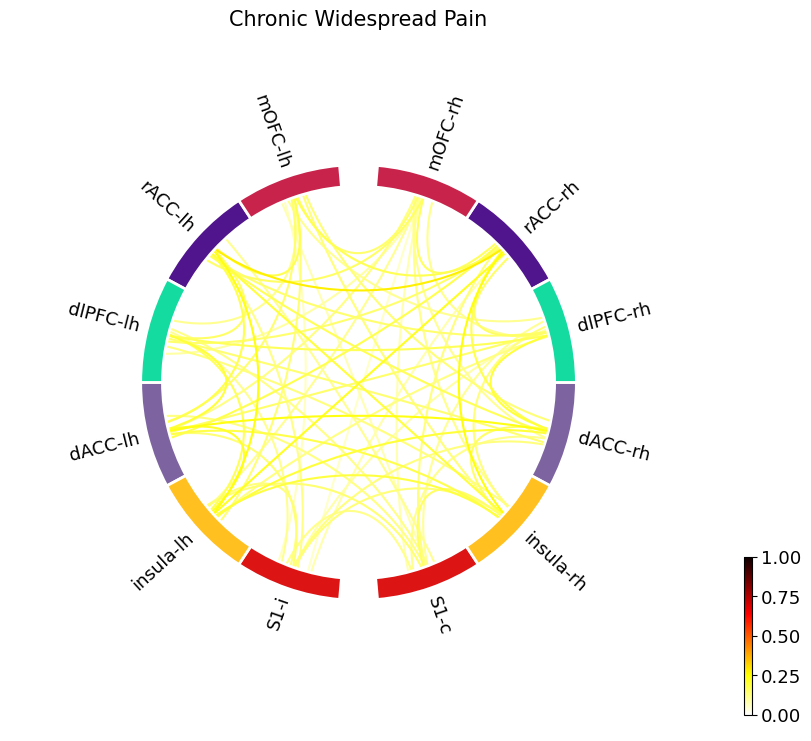

<Figure size 640x480 with 0 Axes>

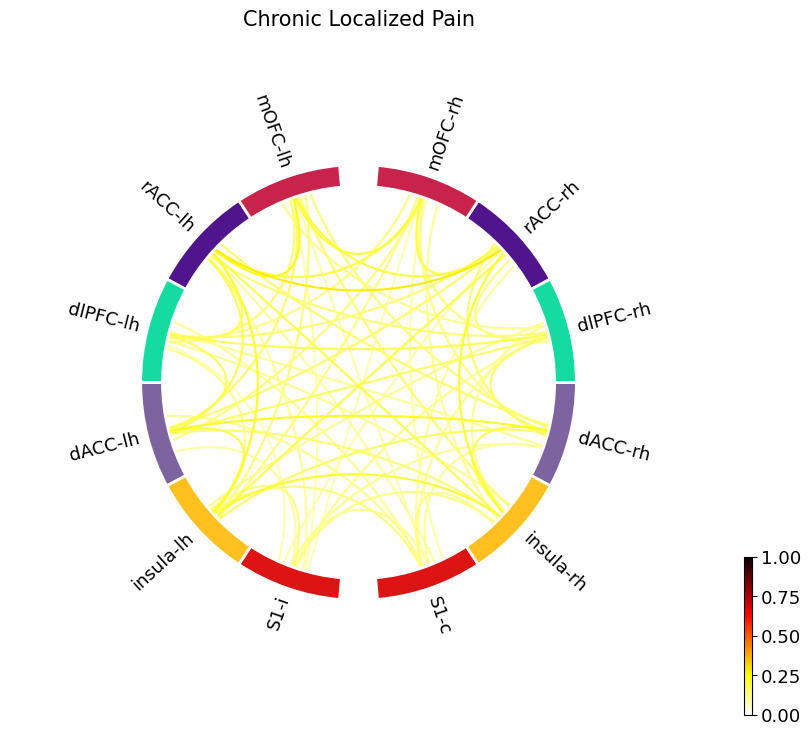

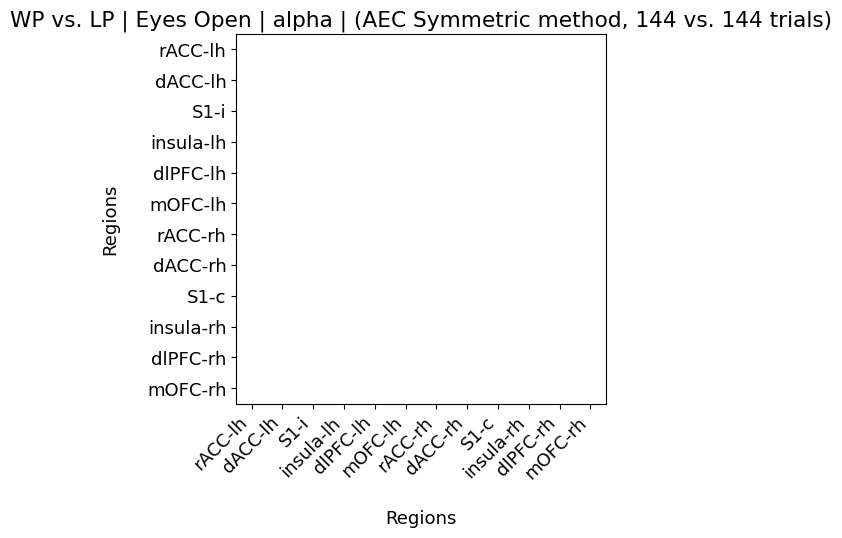

Eyes Open - Chronic Widespread Pain vs. Chronic Localized Pain - aec_symmetric - beta
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   8/12    |     0.27      |
|  dACC-rh <-> dACC-lh  |   6/12    |     0.222     |
| insula-lh <-> rACC-lh |   4/12    |     0.209     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   9/12    |     0.284     |
| insula-lh <-> rACC-lh |   4/12    |     0.372     |
| insula-rh <-> rACC-rh |   3/12    |     0.193     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+----

<Figure size 640x480 with 0 Axes>

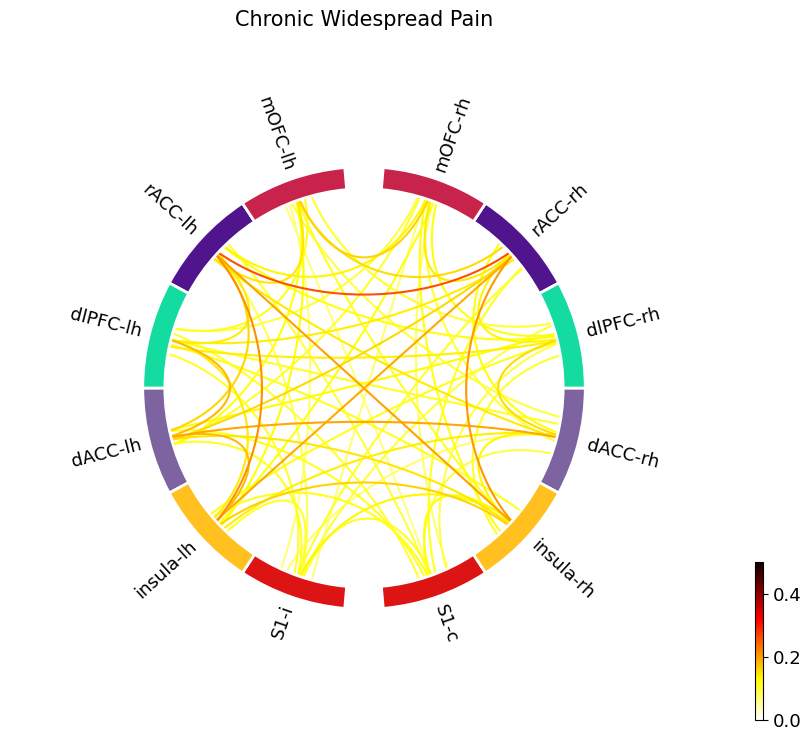

<Figure size 640x480 with 0 Axes>

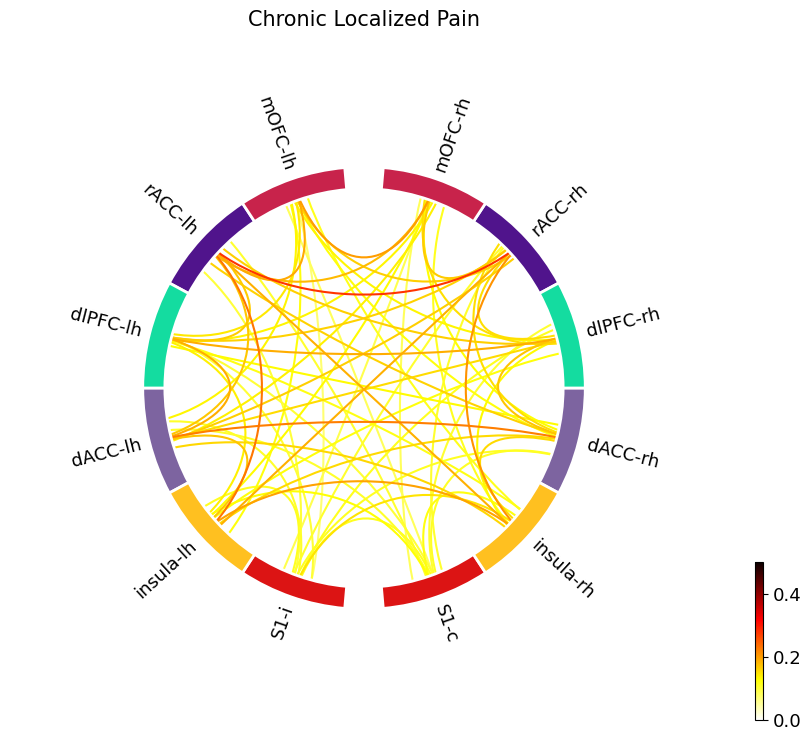

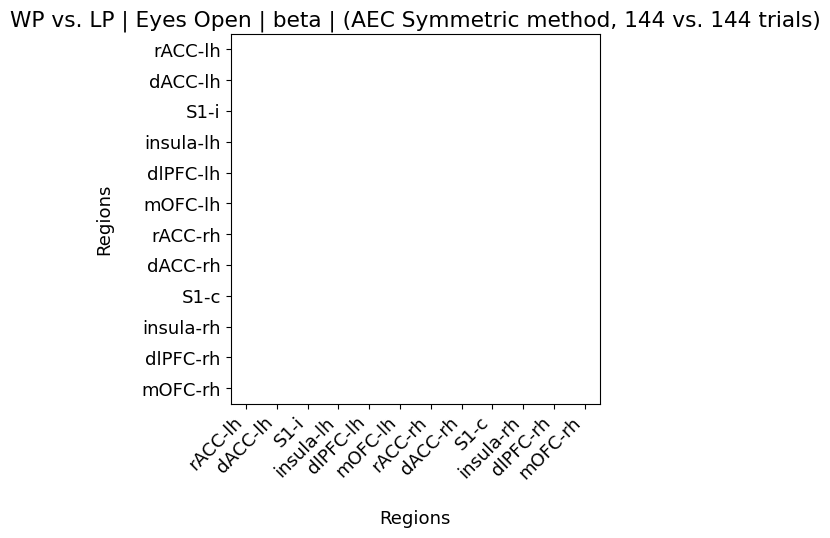

Eyes Open - Chronic Widespread Pain vs. Chronic Localized Pain - aec_symmetric - low-gamma
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   8/12    |     0.285     |
| insula-rh <-> rACC-lh |   4/12    |     0.186     |
| insula-rh <-> rACC-rh |   4/12    |     0.245     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   10/12   |     0.319     |
| insula-rh <-> rACC-rh |   6/12    |     0.182     |
| insula-rh <-> rACC-lh |   4/12    |     0.181     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:


<Figure size 640x480 with 0 Axes>

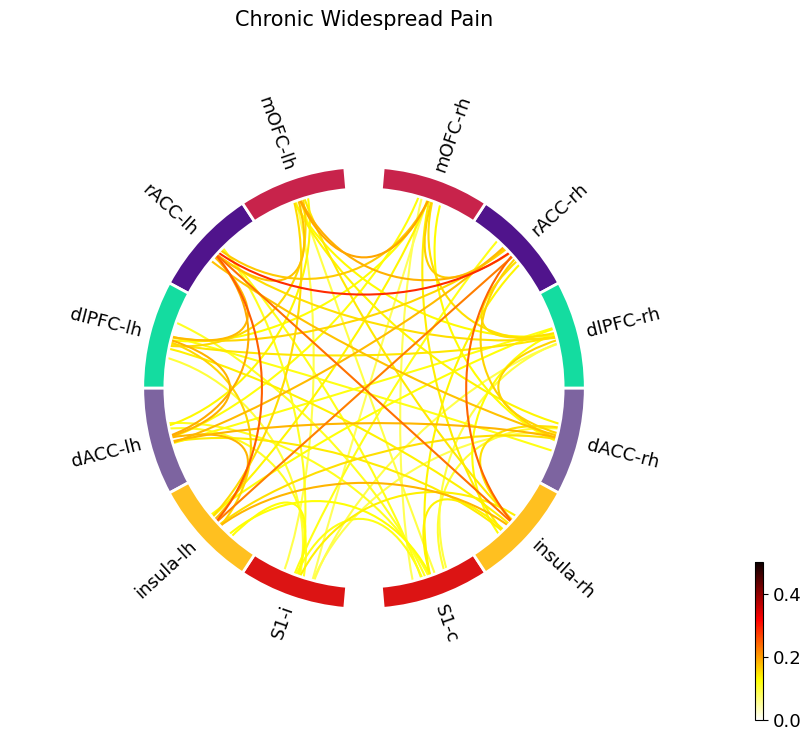

<Figure size 640x480 with 0 Axes>

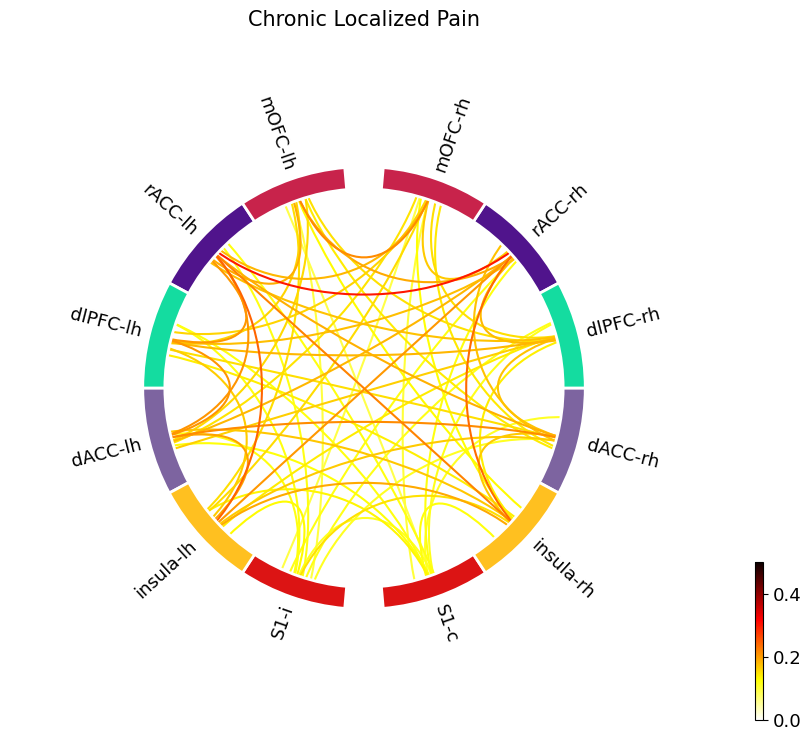

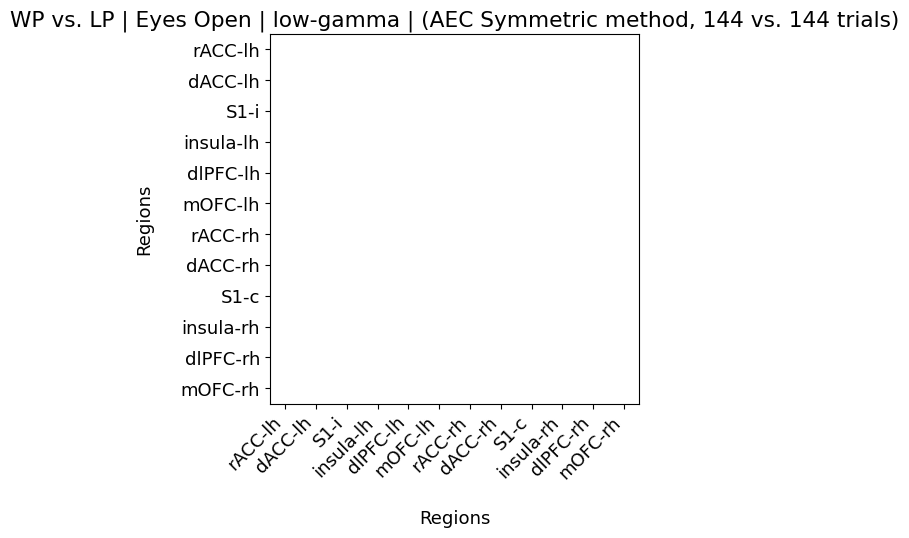

Eyes Open - Chronic Widespread Pain vs. Chronic Localized Pain - aec_symmetric - high-gamma
Top 3 Connections in Chronic Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   9/12    |     0.292     |
| insula-rh <-> rACC-rh |   6/12    |     0.309     |
|  mOFC-rh <-> mOFC-lh  |   3/12    |     0.339     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |   9/12    |     0.35      |
| insula-lh <-> rACC-lh |   5/12    |     0.275     |
| insula-rh <-> rACC-rh |   4/12    |     0.175     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:

<Figure size 640x480 with 0 Axes>

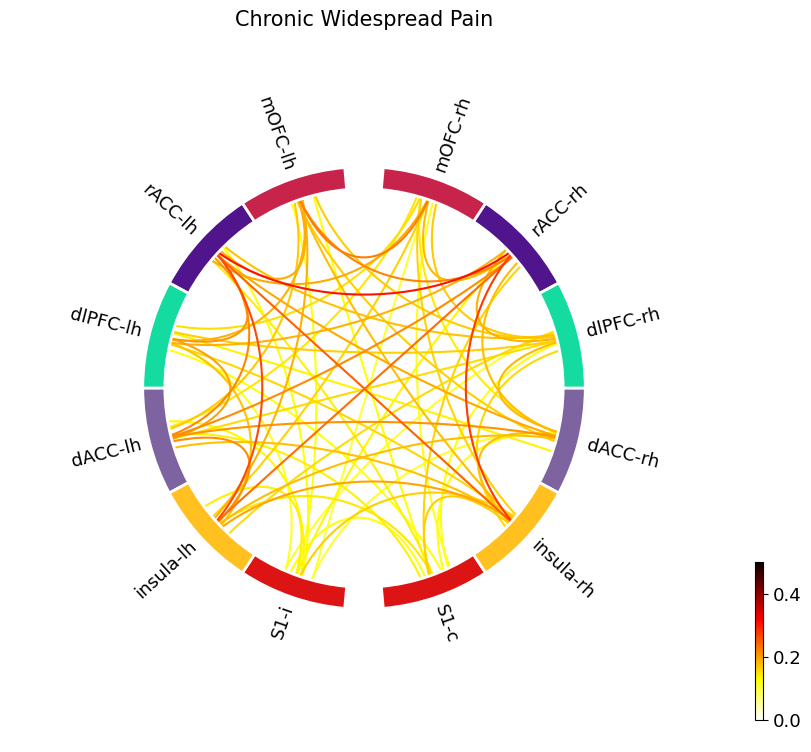

<Figure size 640x480 with 0 Axes>

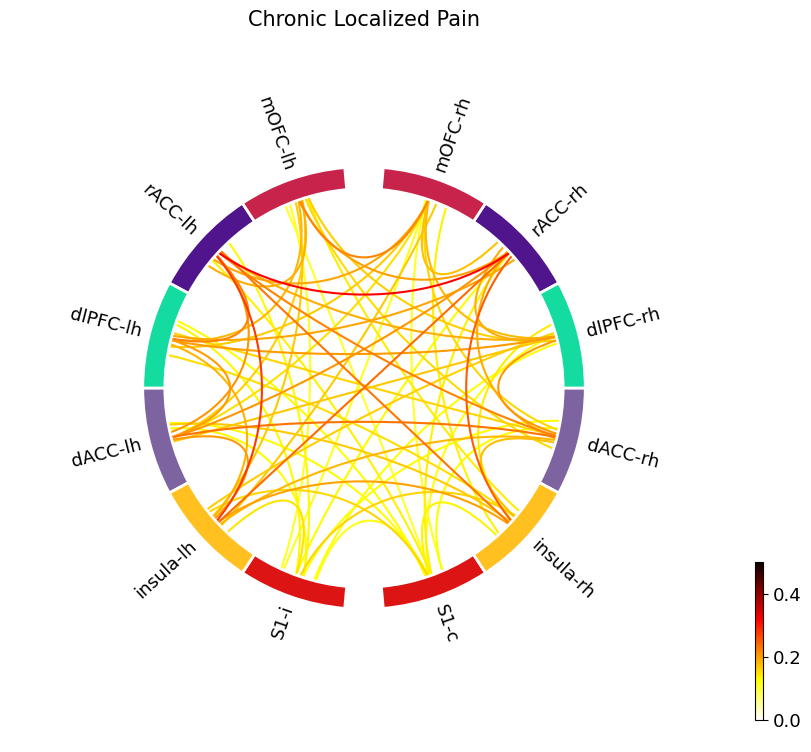

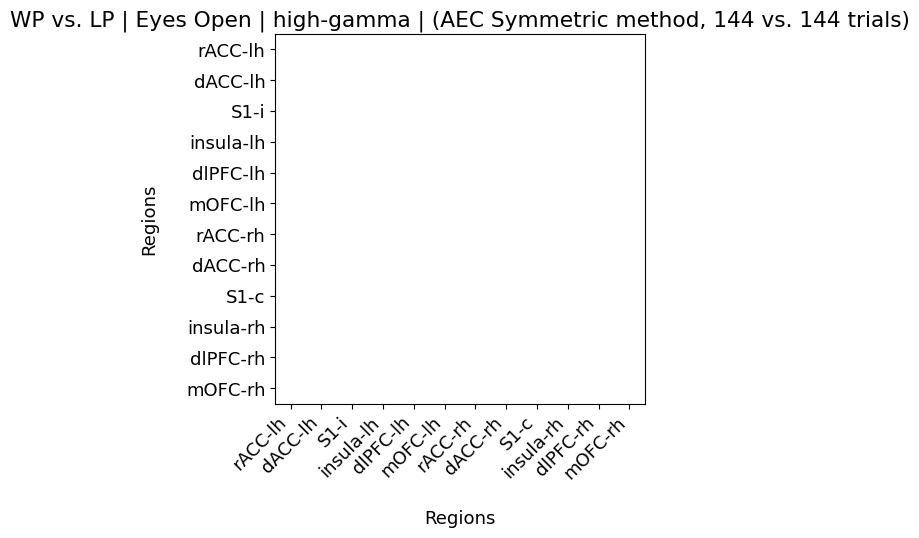

In [41]:
# Widespread Pain vs Localized Pain
these_group_names = ["Chronic Widespread Pain", "Chronic Localized Pain", "Mann_Whitney_U_test"]
these_group_cons = [group_con_WSP, group_con_LP]
these_sub_cons = [sub_con_WSP, sub_con_LP]
these_sub_ids = [sub_ids_WSP, sub_ids_LP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"WP_vs_LP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        # Ignore some specific condition/method combinations
        if condition=="Hand 256 mN" and "aec" in method:
            continue
        elif condition=="Eyes Open" and method=="wpli2_debiased":
            continue

        for band in band_names:
            ## Save all output to a text file
            # Backup original stdout  
            orig_stdout = sys.stdout  
            
            # Open your file in write mode ('w') or append mode ('a') 
            if method=="wpli2_debiased":
                f = open(stats_save_path / f'{condition}_{band}_dwPLI.txt', 'w')  
            else:
                f = open(stats_save_path / f'{condition}_{band}_{method}.txt', 'w')
                
            # Set stdout to the file object  
            if save_txt:
                sys.stdout = f  
            
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            top_3_info=None
            group_con=None
            for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]
                    if 'Eyes' in condition:
                        table_data.append([f"{roi_acronyms_resting[connection[0]]} <-> {roi_acronyms_resting[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                    else:
                        table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                        
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            print(group1_stack.shape)
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack,
                group2_stack,
                roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                sub_ids1=these_sub_ids[0],
                sub_ids2=these_sub_ids[1],
                condition=condition,
                bilateral_pain_ids=bilateral_pain_ids,
                round_neg_vals=round_neg_vals,
                method=method)

            # Need to custom set this because the colors blow out
            if 'Eyes' in condition and band in ["theta","alpha"]:
                vmin = 0.0
                vmax = 1.0
            elif 'Eyes' in condition and band not in ["theta","alpha"]:
                vmin = 0.0
                vmax = 0.5
            else:
                vmin = None
                vmax = None
            
            # Plotting
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                condition=condition,
                vmin=vmin,
                vmax=vmax,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "WP vs. LP",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )
            
            # Compute the centrality and test
            fc.compute_centrality_and_test(group1_stack,
                                        group2_stack, 
                                        roi_acronyms=roi_acronyms if 'Eyes' not in condition else roi_acronyms_resting,
                                        sub_ids1=these_sub_ids[0],
                                        sub_ids2=these_sub_ids[1],
                                        bilateral_pain_ids=bilateral_pain_ids,
                                        condition=condition,
                                        )
            
            print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
            fc.plot_connectivity_and_stats(means_1=means_1,
                                        means_2=means_2,
                                        sem_1=sem_1,
                                        sem_2=sem_2,
                                        p_values=p_values,
                                        **plot_kwargs,
                                        save_fig=True,
                                        highlight_pvals=highlight_pvals,
                                        min_fc_val=None,
                                        set_title=set_title,
                                        show_fc_vals=show_fc_vals,
                                        round_neg_vals=round_neg_vals,
            )
        
            # Reset the standard output to its original value  
            sys.stdout = orig_stdout  
            
            f.close()  
        
            if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(
                            zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(
                            EO_resting_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(
                            EC_resting_data_path, f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
            

## Plot individual data in each group

In [42]:
errorrrr

NameError: name 'errorrrr' is not defined

In [ ]:
# CP Widespread Pain
this_group_name = "Chronic Pain"
this_group_cons = sub_con_CP
n=len(roi_names)

done_subs=[]

subs_gen = (sub_id for sub_id in this_group_cons if sub_id not in done_subs)

for sub_id in subs_gen:
    for condition in conditions:
        # Make a directory for the stats
        stats_save_path = save_path / f"CP_individual_{condition}"
        os.makedirs(stats_save_path, exist_ok=True)
        for method in con_methods:
            for band in band_names:
                # Ignore some specific condition/method combinations
                if condition=="Hand 256 mN" and "aec" in method:
                    continue
                elif condition=="Eyes Open" and method=="wpli2_debiased":
                    continue

                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_name} - {method} - {band}")
                group1_stack = this_group_cons[sub_id][condition][method][band]["data"]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_name,
                    nepochs=[nepochs_1],
                    titles=[f"Subject {sub_id} - {condition} - {method} - {band} ({nepochs_1} trials)"],
                    save_names=[this_group_name],
                    save_path=stats_save_path,
                    )
            
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=None,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(zscored_epochs_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(EO_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(EC_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )

In [ ]:
# CP Widespread Pain
this_group_name = "Healthy Control"
this_group_cons = sub_con_HC
n=len(roi_names)

done_subs=[]

subs_gen = (sub_id for sub_id in this_group_cons if sub_id not in done_subs)

for sub_id in subs_gen:
    for condition in conditions:
        # Make a directory for the stats
        stats_save_path = save_path / f"CP_individual_{condition}"
        os.makedirs(stats_save_path, exist_ok=True)
        for method in con_methods:
            for band in band_names:
                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_name} - {method} - {band}")
                group1_stack = this_group_cons[sub_id][condition][method][band]["data"]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_name,
                    nepochs=[nepochs_1],
                    titles=[f"Subject {sub_id} - {condition} - {method} - {band} ({nepochs_1} trials)"],
                    save_names=[this_group_name],
                    save_path=stats_save_path,
                    )
            
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=None,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(zscored_epochs_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(EO_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(EC_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )